<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn import metrics

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("../Datos/players_21.csv")
df.head(4)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,...,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3


**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [5]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 
                  'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

34 variables numéricas: skills/habilidades


In [6]:
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4512 entries, 0 to 4511
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   attacking_crossing          4512 non-null   int64  
 1   attacking_finishing         4512 non-null   int64  
 2   attacking_heading_accuracy  4512 non-null   int64  
 3   attacking_short_passing     4512 non-null   int64  
 4   attacking_volleys           4512 non-null   int64  
 5   skill_dribbling             4512 non-null   int64  
 6   skill_curve                 4512 non-null   int64  
 7   skill_fk_accuracy           4512 non-null   int64  
 8   skill_long_passing          4512 non-null   int64  
 9   skill_ball_control          4512 non-null   int64  
 10  movement_acceleration       4512 non-null   int64  
 11  movement_sprint_speed       4512 non-null   int64  
 12  movement_agility            4512 non-null   int64  
 13  movement_reactions          4512 

In [7]:
df_skills=df_skills.drop(["defending_marking"], axis=1) ## Se elimina esta skill ya que posee todos valores nulos

In [8]:
df_skills.columns

Index(['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes'],
      dtype='object')

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

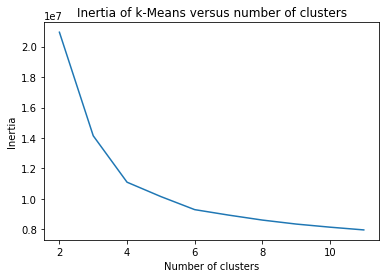

In [9]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

A partir de los resultados del gráfico del codo, podemos observar que el número de clusters más óptimo es 4. A continuación ajustaremos el modelo de kmeans con este número de clusters.

In [10]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11098847.52898096


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [11]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[27]
skill_2=skills_ratings[9]

In [12]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [38]:
#En Colab:
#fig.show(renderer="colab")

In [13]:
#En Jupyter:
#iplot(fig)
plot(fig)

'temp-plot.html'

In [14]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


### Número de observaciones por cluster

In [15]:
df_clusters.kmeans.value_counts()

2    1682
3    1465
0     921
1     444
Name: kmeans, dtype: int64

Se advierte que el Cluster con mayor cantidad de casos es el 2, contando con 1.682 jugadores, seguido por el 0 con 1.465 jugadores. Luego, el Cluster 3 agrupa 921 jugadores y el 1 es el más pequeño, con 444 jugadores.

### Análisis descriptivo de cada cluster

In [16]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==0]
df_clusters_0.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,921.000000,921.000000,921.000000,921.000000,902.000000,921.000000,921.000000,9.210000e+02,921.000000,921.000000,921.000000,921.000000,8.700000e+02,902.000000,902.000000,133.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,0.0,0.0,0.0,0.0,0.0,0.0,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,0.0,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.0
mean,212304.032573,27.363735,185.371336,79.762215,1.118625,73.948969,76.555917,5.648344e+06,21819.218241,1.257329,2.855592,2.170467,1.114785e+07,15.883592,2022.195122,9.338346,61.604777,42.044517,57.517915,59.793702,73.932682,75.352877,NaN,NaN,NaN,NaN,NaN,NaN,50.660152,36.065147,71.675353,67.827362,35.617807,56.519001,43.198697,37.680782,63.028230,64.472313,60.286645,62.647123,57.871878,70.492942,56.891422,56.795874,73.188925,69.807818,78.011944,41.223670,75.978284,73.568947,43.780673,50.559175,44.485342,67.789359,NaN,75.323561,73.221498,10.610206,10.856678,10.729642,10.685125,10.565689,0.0
std,24577.584575,4.036134,5.618003,6.197907,0.326939,3.012763,4.298555,5.831588e+06,22985.856943,0.543752,0.598725,0.376247,1.158149e+07,14.768159,1.158695,6.621690,12.565833,8.171609,6.573659,7.607834,4.183278,5.032537,NaN,NaN,NaN,NaN,NaN,NaN,14.177548,9.487067,7.709814,5.893581,9.826841,10.190358,11.721062,11.408814,7.941174,6.442180,12.741337,13.144610,11.821539,4.779053,12.209010,11.730193,11.046007,10.357049,7.833656,12.738248,7.219355,4.840036,12.133393,10.745728,9.995437,6.473284,NaN,4.185583,4.442484,3.433382,3.331516,3.353726,3.301957,3.436422,0.0
min,20209.000000,18.000000,165.000000,60.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,7.130000e+05,2.000000,2020.000000,2.000000,30.000000,18.000000,35.000000,34.000000,64.000000,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,15.000000,37.000000,42.000000,11.000000,23.000000,14.000000,10.000000,20.000000,33.000000,28.000000,30.000000,26.000000,54.000000,27.000000,22.000000,31.000000,30.000000,33.000000,12.000000,41.000000,60.000000,12.000000,17.000000,13.000000,46.000000,NaN,63.000000,59.000000,3.000000,3.000000,1.000000,4.000000,3.000000,0.0
25%,198230.000000,24.000000,182.000000,75.000000,1.000000,72.000000,73.000000,2.600000e+06,8000.000000,1.000000,3.000000,2.000000,4.925000e+06,4.000000,2021.000000,4.000000,54.000000,36.000000,53.000000,54.000000,71.000000,73.000000,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,29.000000,68.000000,65.000000,28.000000,50.000000,34.000000,30.000000,58.000000,61.000000,53.000000,54.000000,51.000000,67.000000,49.000000,48.000000,68.000000,65.000000,74.000000,31.000000,72.000000,70.000000,34.000000,44.000000,38.000000,64.000000,NaN,72.000000,70.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.0
50%,214639.000

In [17]:
df_clusters_1=df_clusters[df_clusters["kmeans"]==1]
df_clusters_1.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,444.000000,444.000000,444.000000,444.000000,433.000000,444.000000,444.000000,4.440000e+02,444.000000,444.000000,444.000000,444.0,4.210000e+02,433.000000,433.000000,99.000000,0.0,0.0,0.0,0.0,0.0,0.0,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,0.0,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.0
mean,197309.355856,29.772523,189.157658,83.795045,1.117783,75.360360,76.975225,6.369595e+06,21164.414414,1.342342,2.666667,1.0,1.245767e+07,16.013857,2022.129330,10.525253,NaN,NaN,NaN,NaN,NaN,NaN,75.594595,72.664414,70.373874,77.060811,44.448198,74.567568,14.966216,13.092342,14.921171,30.677928,13.605856,15.450450,15.707207,15.029279,29.815315,22.837838,44.590090,44.344595,46.182432,71.405405,44.860360,52.918919,64.576577,34.227477,66.247748,13.896396,29.076577,19.527027,12.698198,46.765766,21.819820,53.195946,NaN,14.677928,14.268018,75.594595,72.664414,70.373874,74.567568,77.060811,1.0
std,35290.571053,4.386524,4.520573,6.020722,0.329819,4.078336,4.755115,8.744030e+06,29145.912124,0.658276,0.724712,0.0,1.767175e+07,20.198891,1.189029,8.624057,NaN,NaN,NaN,NaN,NaN,NaN,4.497561,4.683432,6.085163,4.657904,8.844507,4.538517,4.517958,3.400708,4.361809,9.164282,3.506854,4.391123,5.275681,4.865834,10.242087,6.555945,9.481763,9.120250,11.741403,5.433993,10.563293,4.564828,10.190997,6.677347,9.561344,3.340440,8.083285,5.170824,3.629438,13.600694,7.383036,11.969860,NaN,3.408575,3.197454,4.497561,4.683432,6.085163,4.538517,4.657904,0.0
min,1179.000000,20.000000,175.000000,64.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,1.0,3.240000e+05,1.000000,2020.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,61.000000,62.000000,44.000000,66.000000,18.000000,62.000000,6.000000,5.000000,7.000000,11.000000,4.000000,7.000000,6.000000,7.000000,9.000000,5.000000,17.000000,15.000000,19.000000,50.000000,20.000000,33.000000,32.000000,15.000000,33.000000,4.000000,11.000000,6.000000,3.000000,10.000000,9.000000,12.000000,NaN,7.000000,7.000000,61.000000,62.000000,44.000000,62.000000,66.000000,1.0
25%,183435.000000,27.000000,186.000000,80.000000,1.000000,72.000000,73.000000,1.900000e+06,6000.000000,1.000000,2.000000,1.0,3.500000e+06,1.000000,2021.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,69.000000,66.000000,74.000000,39.000000,72.000000,12.000000,11.000000,12.000000,24.000000,11.000000,12.000000,12.000000,12.000000,22.000000,19.000000,38.000000,38.000000,37.000000,68.000000,38.000000,50.000000,59.000000,30.000000,60.000000,12.000000,23.000000,15.750000,11.000000,38.750000,17.000000,47.000000,NaN,12.000000,12.000000,72.000000,69.000000,66.000000,72.000000,74.000000,1.0
50%,201628.000000,30.000000,189.000000,83.000000,1.000

In [18]:
df_clusters_1=df_clusters[df_clusters["kmeans"]==2]
df_clusters_1.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,1682.000000,1682.000000,1682.000000,1682.000000,1650.000000,1682.000000,1682.000000,1.682000e+03,1682.000000,1682.000000,1682.000000,1682.000000,1.592000e+03,1650.000000,1650.000000,318.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,0.0,0.0,0.0,0.0,0.0,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.0
mean,210344.030321,27.387039,179.232461,73.909037,1.096364,75.165279,77.344233,7.798796e+06,29296.967895,1.368014,3.168847,3.017241,1.530484e+07,18.323030,2022.314545,11.547170,70.719382,62.878716,71.149822,73.206302,69.131986,71.674197,NaN,NaN,NaN,NaN,NaN,NaN,69.662901,58.448276,61.437574,74.988109,56.335315,72.626635,67.384067,59.526159,71.124851,74.715815,71.057669,70.424495,72.372771,73.031510,71.549346,71.558264,68.993460,77.993460,68.422711,65.766944,72.501189,70.620095,66.832342,69.666468,58.325803,72.130797,NaN,71.236029,68.483353,10.579667,10.638526,10.737812,10.664685,10.607610,2.0
std,24075.663614,3.875136,5.683613,5.935259,0.303285,3.600189,4.485663,8.124070e+06,34869.263046,0.645858,0.689881,0.552158,1.612342e+07,15.335283,1.204336,6.477525,10.106734,7.873375,5.071543,4.840552,6.618916,6.577387,NaN,NaN,NaN,NaN,NaN,NaN,8.021308,10.212029,9.973849,5.108098,11.489511,5.897676,9.646269,12.846121,6.711696,4.881716,10.038338,10.834675,8.147629,5.241765,9.379513,8.067635,10.661157,8.379067,9.389973,9.532144,8.950937,6.972464,7.463443,7.956825,10.840564,6.444714,NaN,6.736800,7.979302,3.270096,3.325869,3.443897,3.452653,3.226436,0.0
min,41.000000,17.000000,164.000000,56.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,6.160000e+05,2.000000,2020.000000,2.000000,30.000000,39.000000,57.000000,55.000000,46.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,34.000000,20.000000,22.000000,58.000000,21.000000,48.000000,31.000000,23.000000,42.000000,55.000000,31.000000,29.000000,34.000000,56.000000,32.000000,28.000000,31.000000,41.000000,30.000000,30.000000,30.000000,41.000000,33.000000,35.000000,25.000000,52.000000,NaN,47.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
25%,194782.250000,24.000000,175.000000,70.000000,1.000000,72.000000,74.000000,3.100000e+06,10000.000000,1.000000,3.000000,3.000000,6.000000e+06,8.000000,2021.000000,6.000000,65.000000,58.000000,68.000000,70.000000,66.000000,68.000000,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,52.000000,55.000000,72.000000,49.000000,69.000000,62.000000,50.000000,67.000000,72.000000,66.000000,65.000000,67.000000,69.000000,66.000000,67.000000,62.000000,73.000000,63.250000,60.000000,67.000000,67.000000,63.000000,65.000000,51.000000,68.000000,NaN,68.000000,64.000000,8.000000,8.000000,

In [19]:
df_clusters_3=df_clusters[df_clusters["kmeans"]==3]
df_clusters_3.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,1465.000000,1465.00000,1465.000000,1465.000000,1438.000000,1465.000000,1465.000000,1.465000e+03,1465.000000,1465.000000,1465.000000,1465.000000,1.376000e+03,1438.000000,1438.000000,240.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,0.0,0.0,0.0,0.0,0.0,0.0,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.00000,0.0,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.0
mean,211502.774061,27.08942,179.020478,74.208191,1.088317,74.931741,77.223208,8.511945e+06,28684.641638,1.397952,3.384300,3.392491,1.664208e+07,18.457580,2022.311544,14.220833,76.008191,72.131741,67.823208,75.606143,37.592491,65.645734,NaN,NaN,NaN,NaN,NaN,NaN,65.591809,72.713993,60.918089,71.536519,67.350171,75.868259,67.954266,60.627986,61.805461,75.813652,76.354949,75.729010,76.404096,72.559727,72.537201,74.731058,66.489420,69.992491,66.225939,69.847782,58.466894,34.662116,74.450512,69.651877,67.483959,72.00000,NaN,34.566553,30.352218,10.570648,10.620478,10.606826,10.512628,10.445734,3.0
std,27315.567568,4.10395,6.795077,7.209468,0.283854,3.712626,4.838372,9.998090e+06,39074.573200,0.710477,0.716053,0.612549,1.961454e+07,15.889426,1.287061,5.235578,10.362814,5.460587,7.204526,5.337883,7.989650,9.078180,NaN,NaN,NaN,NaN,NaN,NaN,10.915407,6.393792,14.234141,5.658321,8.695571,5.866780,10.612973,13.712511,10.386570,4.978652,11.067214,10.383277,10.385756,5.835110,12.146595,6.598768,13.509663,9.224615,13.381391,7.084630,13.868002,10.932285,5.858804,7.881138,8.719830,6.69179,NaN,11.340898,10.153341,3.110328,3.087630,3.132494,3.137776,3.217517,0.0
min,3467.000000,17.00000,157.000000,55.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,1.100000e+06,2.000000,2020.000000,3.000000,30.000000,54.000000,44.000000,58.000000,18.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,51.000000,20.000000,53.000000,32.000000,57.000000,26.000000,22.000000,25.000000,57.000000,27.000000,30.000000,30.000000,56.000000,27.000000,39.000000,30.000000,30.000000,27.000000,40.000000,23.000000,10.000000,53.000000,39.000000,34.000000,51.00000,NaN,11.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0
25%,198429.000000,24.00000,174.000000,69.000000,1.000000,72.000000,73.000000,3.300000e+06,10000.000000,1.000000,3.000000,3.000000,6.100000e+06,9.000000,2021.000000,10.000000,70.000000,69.000000,64.000000,72.000000,32.000000,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,61.000000,68.000000,49.000000,68.000000,62.000000,72.000000,62.000000,51.000000,56.000000,73.000000,71.000000,70.000000,71.000000,69.000000,66.000000,71.000000,58.000000,66.000000,58.000000,66.000000,48.000000,26.000000,71.000000,65.000000,62.000000,68.00000,NaN,26.000000,22.000000,8.000000,8.000000

A partir del análisis descriptivo de los clusters pudimos detectar algunas diferencias entre ellos. Por ejemplo, los jugadores pertenecientes a los clusters 1 y 3 poseen en promedio mayor altura y peso que los pertenecientes a los clusters 2 y 0. Una tendencia similar entre grupos se observó con respecto al sueldo de los jugadores, siendo en promedio mayor para los que se encuentran incluidos en los grupos 2 y 0 con respecto a los clusters 1 y 3.

### Relación de los clusters con variables categóricas

<AxesSubplot:xlabel='team_position', ylabel='kmeans'>

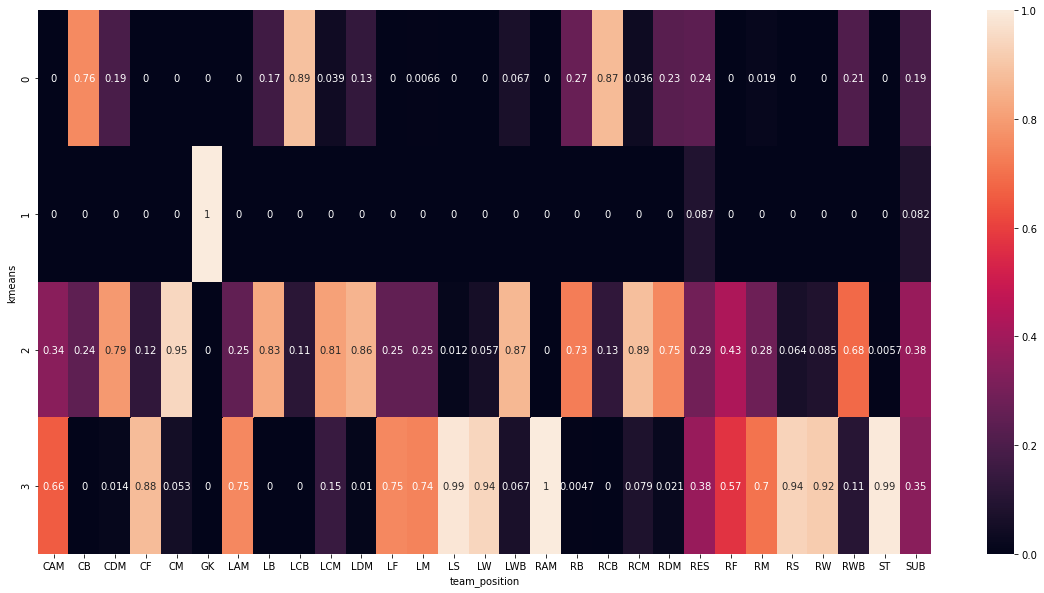

In [20]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_clusters.team_position, normalize='columns'),annot=True)

##Grupo 1 arqueros 
## Grupo 0 defensores
## Grupo 2 mediocampo
##Grupo 3 delanteros

El gráfico del análisis de la tabla de contingencia nos muestra una marcada asociación entre los clusters y la posición de los jugadores en el equipo. Como se puede observar, todos los arqueros (GK) se encuentran incluidos en el cluster 1. Por otro lado, los defensores (ej. LB, RCB, CB) se encontraron en mayor proporción en el grupo 0, mientras que la mayor proporción de mediocampistas (ej. CM, RCM, LDM), fueron incluidos en el grupo 2. Finalmente, los delanteros (ej. RAM, ST, LS) se encontraron en una proporción mayor en el cluster 3.   

<AxesSubplot:xlabel='club_name', ylabel='kmeans'>

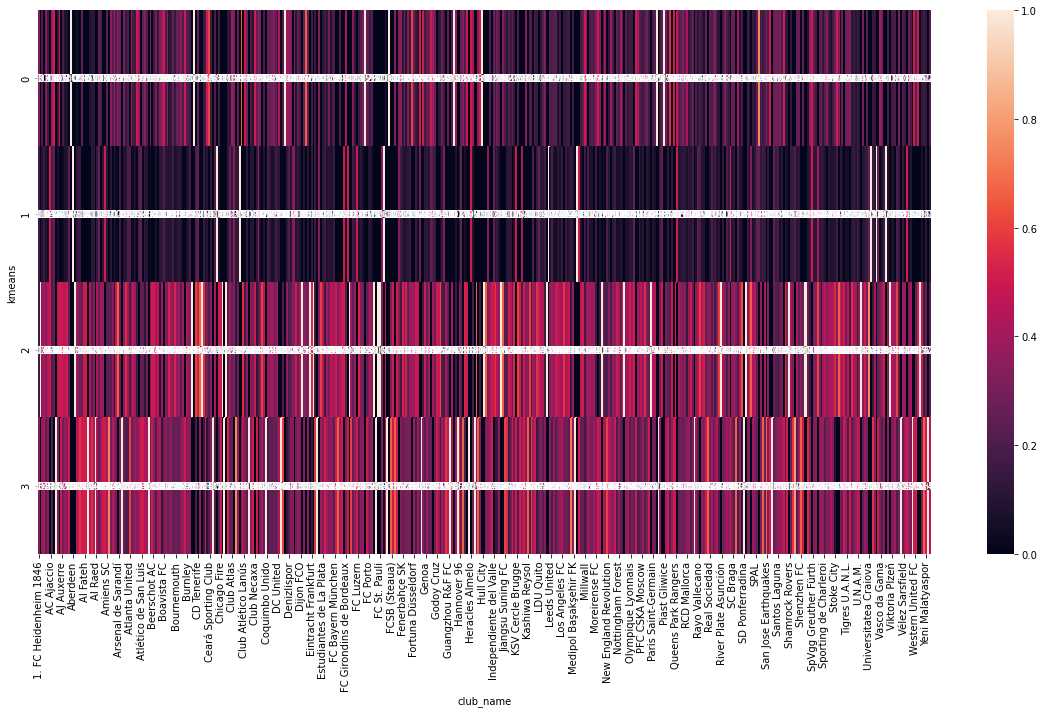

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_clusters.club_name, normalize="columns"),annot=True)

En este gráfico se puede observar una asociación, aunque no muy clara, de ciertos club a determinados clusters. Esto puede evidenciarse observando las proporciones de los clubes en cada cluster (los colores más claros muestran proporciones más altas). **Podemos restringirlo a clubes con mayor cantidad de observaciones si quieren para hacer una interpretación más detallada(Lau)**

<AxesSubplot:xlabel='nationality', ylabel='kmeans'>

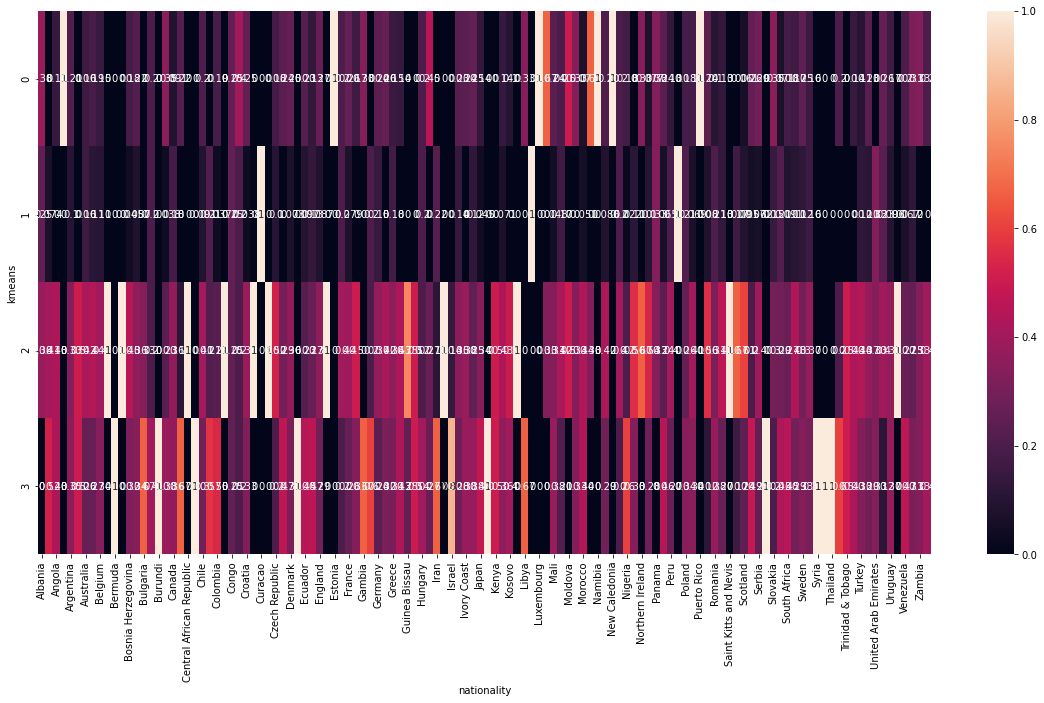

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_clusters.nationality, normalize="columns"),annot=True)

Al igual que en el caso anterior, obervamos una asociación entre la nacionalidad de los jugadores y el número de cluster en el cual se encuentran incluidos. Esta asociación puede evidenciarse por las propociones de la nacionalidad para cada cluster. **Acá también, podemos restringirlo a nacionalidades con mayor cantidad de observaciones (Lau)**

<AxesSubplot:xlabel='team_jersey_number', ylabel='kmeans'>

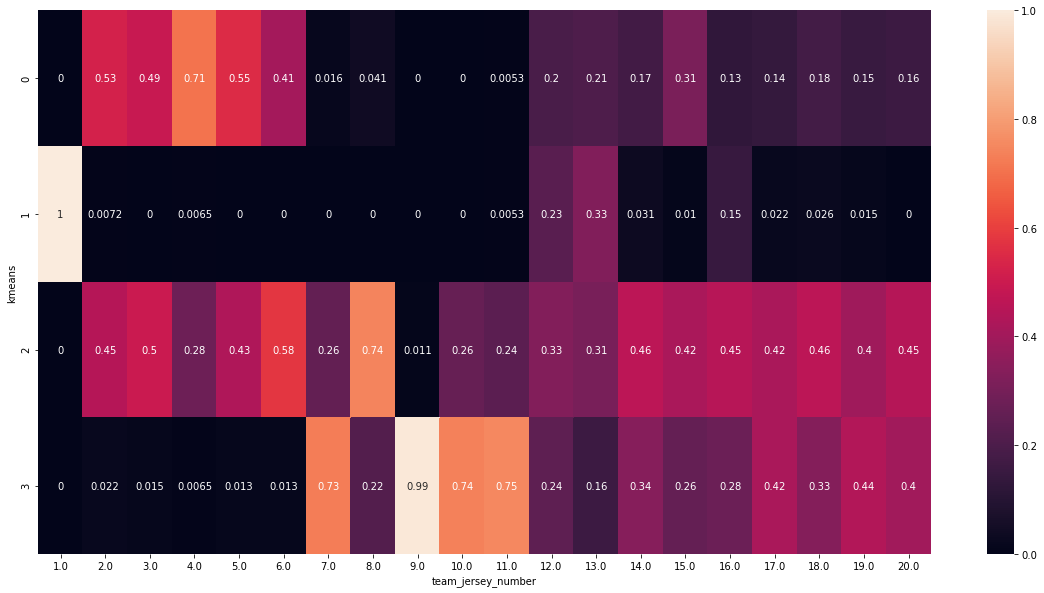

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters[df_clusters["team_jersey_number"]<=20]["kmeans"], df_clusters[df_clusters["team_jersey_number"]<=20]["team_jersey_number"], normalize="columns"),annot=True)

En este caso, podemos observar que los clusters también se asocian a números de camiseta particulares, los cuales a su vez están relacionadas a las posiciones de los jugadores en el equipo. Por ejemplo, la totalidad de las camisetas con el número 1 están incluidas en el cluster 1 y corresponden a los arqueros. La mayor proporción de camisetas con el número 4 se asocian al cluster 0 y pertenecen a los jugadores defensores. Por otro lado, la mayor proporción de camisetas con el número 8 se encuentran en el cluster 2 y están asociadas a jugadores de mediocampo. Por último, la mayor cantidad de jugadores con las camisetas 9, 10 y 7 se encuentran en el cluster 3 y se asocian a jugadores que son delanteros.

### Gráfico de silueta

Automatically created module for IPython interactive environment
Para n_clusters = 2 El silhouette_score promedio es : 0.6413157990914239
Para n_clusters = 3 El silhouette_score promedio es : 0.33693767836491945
Para n_clusters = 4 El silhouette_score promedio es : 0.30988045957867183
Para n_clusters = 5 El silhouette_score promedio es : 0.2774230749072337
Para n_clusters = 6 El silhouette_score promedio es : 0.23810817661502381


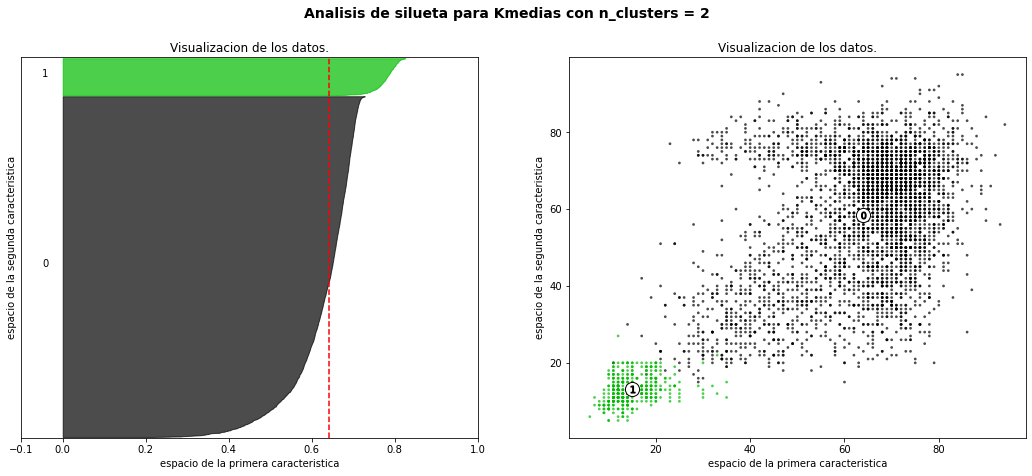

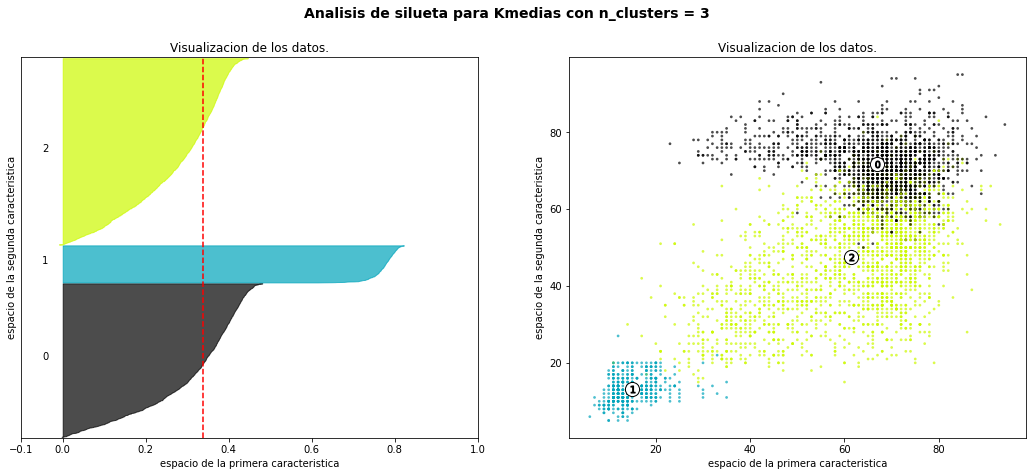

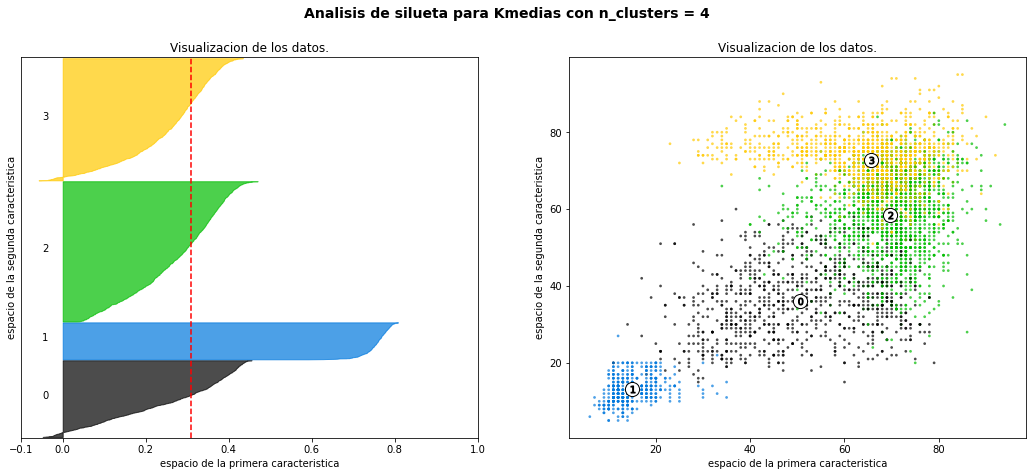

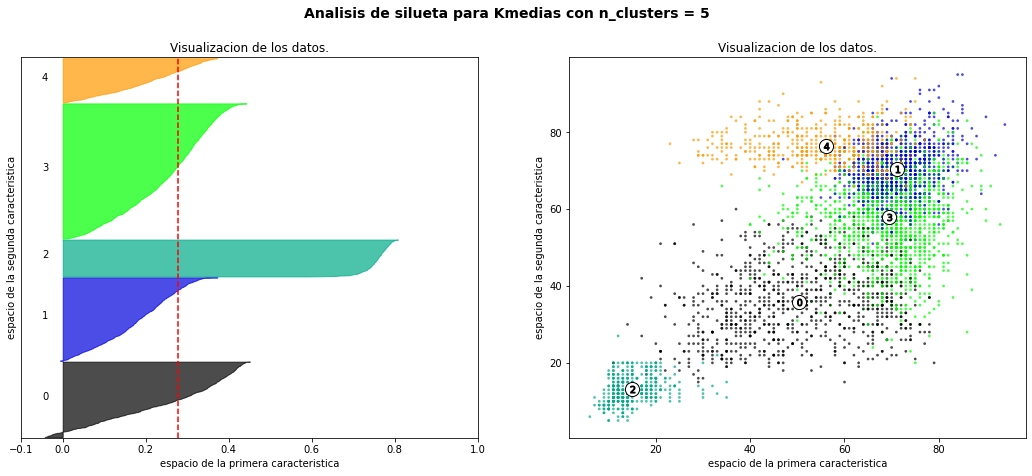

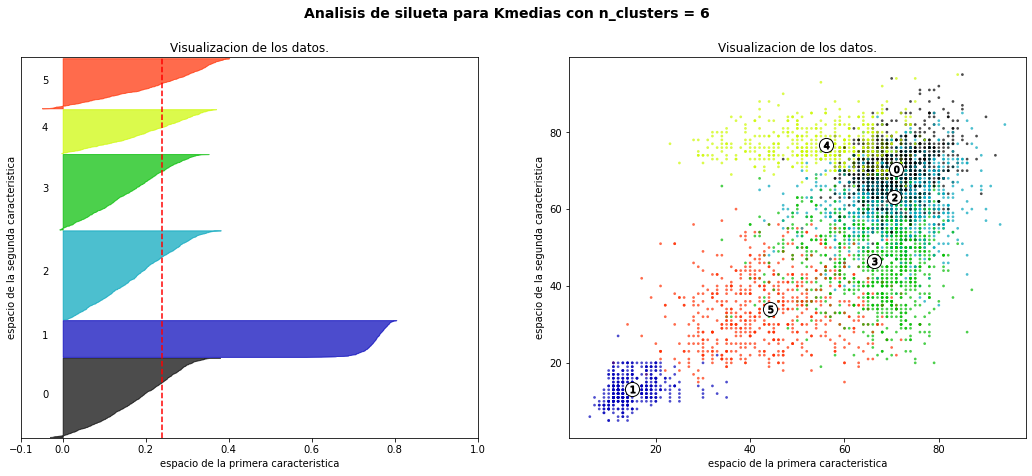

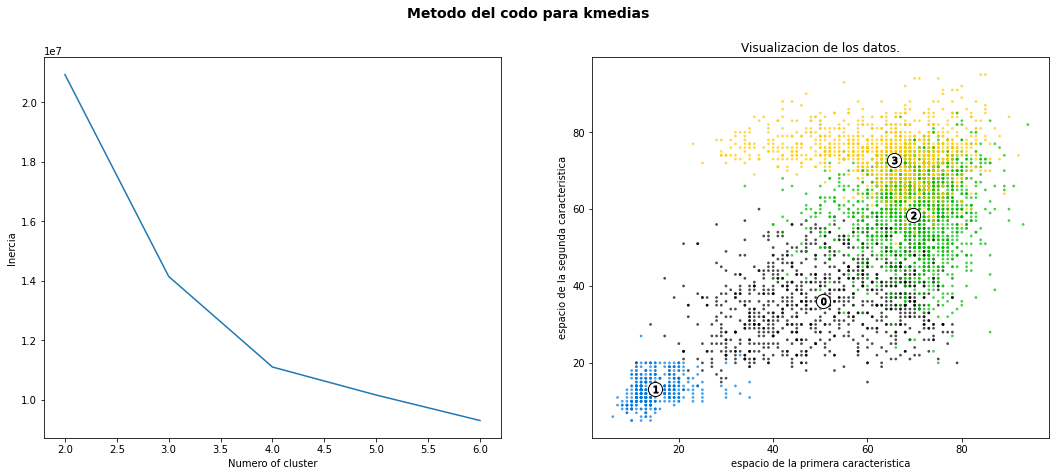

In [24]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X=df_skills

range_n_clusters = [2,3, 4, 5, 6]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()

El gráfico de silueta muestra un mayor balance de clases para un número de cluster igual a 4, apoyando el resultado obtenido del gráfico de codo. **Aca se me generaron algunas dudas: a partir del cluster 4 tenemos valores negativos de silueta, en ese sentido sería mejor el de 3 clusters no? (Lau)**

**COMENT FC:** Acá se ve lo que me generaba dudas a mi en el gráfico de silueta. Encontré lo mismo que vos Lau, y el tema de los valores negativos me hacía generar dudas. Además, tampoco es que lo veo reeee balanceado. 

Este gráfico obtenido a partir del análisis de kmeans nos permite diferenciar claramente a uno de los clusters por sobre los restantes, que no presentan una separación tan clara entre ellos. El cluster diferenciado, como se explicó anteriormente, esta compuesto por los arqueros que presentan habilidades muy diferentes a la de los jugadores de otras posiciones. Si bien los tres clusters restantes no se separan tan claramente, pudimos detectar asociaciones bastante importantes entre ellos y las posiciones de jugadores defensores, mediocampistas y delanteros. Además, pudimos observar una asociación de los clusters con el número de las camisetas de los jugadores que, a su vez, se relacionaron con la posición de los mismos. Por otro lado, también observamos ciertas relaciones de otras variables categóricas como la nationalidad y el club al cual pertenecen los jugadores, como así también de variables numéricas (peso, altura y sueldo), con los clusters. Los jugadores pertenecientes a los clusters 0 y 1, asociados mayormente a las posiciones de arquero y defensores, respectivamente, suelen tener contexturas mayores (mayor altura y peso) y menores salarios que aquellos pertenecientes a los clusters 2 y 3, mayormente asociados a mediocampistas y delanteros, respectivamente. 

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [27]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


Graficamos los resultados:

In [28]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[27]
skill_2=skills_ratings[9]

In [29]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [30]:
#En Colab
#fig.show(renderer="colab")
plot(fig)

'temp-plot.html'

In [31]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


### Número de observaciones por cluster

In [30]:
df_clusters.MeanShift.value_counts() ## Existe un desbalance entre las clases

0    1975
2    1599
1     938
Name: MeanShift, dtype: int64

Se advierte que el Cluster con mayor cantidad de casos es el 0, contando con 1.975 jugadores, seguido por el 2 con 1.599 jugadores. Por último, el Cluster 3 agrupa 938 jugadores.

**Pregunta: normalizamos/estandarizamos la base?** En este caso, no es necesario entandarizar las variables (eg. skills) debido a que todas ellas se encuentran entre valores que van del 0 al 100. 

### Análisis descriptivo por clusters

In [32]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==0]
df_clusters_0.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,1975.000000,1975.000000,1975.000000,1975.000000,1930.000000,1975.000000,1975.000000,1.975000e+03,1975.000000,1975.000000,1975.000000,1975.000000,1.852000e+03,1930.000000,1930.000000,283.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,0.0,0.0,0.0,0.0,0.0,0.0,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,0.0,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.0
mean,212806.134684,27.255696,181.098734,75.707848,1.122280,73.816709,76.252658,5.314291e+06,20366.075949,1.221266,2.984304,2.613671,1.045172e+07,17.330052,2022.206218,10.049470,68.183797,51.617215,63.842025,66.532152,69.370127,71.830886,NaN,NaN,NaN,NaN,NaN,NaN,61.252658,46.298734,64.241519,70.300253,45.352911,64.598481,56.056709,48.951899,65.699241,68.982278,67.792911,68.474937,66.809114,70.671392,65.961519,63.145316,70.584304,73.038987,70.981266,52.675443,72.641013,69.693671,54.986329,59.262278,51.626835,68.788354,NaN,71.273924,69.087595,10.615696,10.836456,10.787342,10.562025,10.537722,1.160506,0.0
std,23814.289097,3.998852,6.662426,6.939762,0.333962,2.762431,4.109132,4.634999e+06,20650.052892,0.497362,0.656398,0.627078,9.277094e+06,15.423195,1.182191,6.663468,12.124236,11.804053,7.979289,8.668840,8.587839,6.919845,NaN,NaN,NaN,NaN,NaN,NaN,14.558183,13.645604,11.303983,5.511844,13.814868,10.946878,15.699361,16.045030,7.415698,6.720215,12.583708,12.402987,12.572365,4.571161,13.090734,11.572364,11.285592,10.072533,10.923709,15.330254,9.341611,9.109479,14.272650,12.234705,12.274552,6.000234,NaN,8.350989,9.412150,3.382813,3.367267,3.473790,3.432085,3.358286,1.084131,0.0
min,20209.000000,17.000000,163.000000,55.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,6.160000e+05,2.000000,2020.000000,2.000000,30.000000,18.000000,35.000000,34.000000,32.000000,41.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,15.000000,22.000000,42.000000,11.000000,23.000000,14.000000,10.000000,20.000000,33.000000,28.000000,30.000000,26.000000,54.000000,27.000000,22.000000,31.000000,30.000000,30.000000,12.000000,29.000000,23.000000,12.000000,17.000000,13.000000,46.000000,NaN,34.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0
25%,199240.000000,24.000000,176.000000,70.000000,1.000000,72.000000,73.000000,2.700000e+06,8000.000000,1.000000,3.000000,2.000000,5.000000e+06,5.000000,2021.000000,4.000000,62.000000,43.000000,59.000000,62.000000,67.000000,68.000000,NaN,NaN,NaN,NaN,NaN,NaN,52.000000,36.000000,57.000000,67.000000,34.000000,59.000000,44.000000,35.000000,62.000000,65.000000,61.000000,63.000000,60.000000,68.000000,59.000000,56.000000,65.000000,68.000000,65.000000,41.000000,68.000000,67.000000,45.000000,51.00000

In [33]:
df_clusters_1=df_clusters[df_clusters["MeanShift"]==1]
df_clusters_1.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,938.000000,938.000000,938.000000,938.000000,929.000000,938.000000,938.000000,9.380000e+02,938.000000,938.000000,938.000000,938.000000,9.110000e+02,929.000000,929.000000,224.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,0.0,0.0,0.0,0.0,0.0,0.0,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,0.0,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.0
mean,205028.035181,27.816631,181.026652,75.607676,1.057051,76.961620,78.855011,1.139667e+07,42058.102345,1.630064,3.319829,3.202559,2.194605e+07,17.443488,2022.411195,12.821429,67.353945,69.255864,73.783582,75.268657,66.051173,72.963753,NaN,NaN,NaN,NaN,NaN,NaN,69.270789,66.382729,64.157783,77.849680,63.093817,75.199360,69.513859,63.384861,74.074627,77.638593,67.811301,66.973348,70.962687,75.696162,69.704691,75.997868,67.360341,77.905117,71.199360,71.448827,72.479744,67.231343,71.719616,74.478678,62.131130,75.719616,NaN,67.700426,63.119403,10.535181,10.454158,10.531983,10.865672,10.641791,2.134328,1.0
std,26340.792545,3.880342,6.050158,6.375114,0.236662,3.985917,4.621914,1.084782e+07,45874.173455,0.815166,0.691503,0.629677,2.128760e+07,13.653158,1.213663,6.051667,11.161973,6.574148,5.351774,5.619973,11.206681,7.057075,NaN,NaN,NaN,NaN,NaN,NaN,9.655608,8.598330,10.903606,4.599407,11.238358,6.350969,10.891055,12.867773,6.342651,4.842502,11.438276,11.623144,10.097798,5.320307,11.636948,6.145687,12.070418,9.321974,9.659171,7.563749,10.105216,12.761702,7.140551,6.185679,11.394211,6.074182,NaN,11.907273,13.848341,3.170256,3.223534,3.195772,3.306001,3.205126,0.531881,0.0
min,41.000000,17.000000,158.000000,56.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,7.500000e+05,2.000000,2020.000000,2.000000,30.000000,46.000000,51.000000,53.000000,24.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,34.000000,31.000000,63.000000,26.000000,45.000000,30.000000,28.000000,37.000000,58.000000,27.000000,29.000000,32.000000,60.000000,30.000000,47.000000,30.000000,32.000000,33.000000,36.000000,29.000000,12.000000,43.000000,34.000000,27.000000,52.000000,NaN,28.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0
25%,190420.000000,25.000000,177.000000,71.000000,1.000000,74.000000,75.000000,4.725000e+06,14250.000000,1.000000,3.000000,3.000000,8.550000e+06,8.000000,2021.000000,8.000000,62.000000,65.000000,71.000000,72.000000,59.000000,69.000000,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,60.000000,58.000000,75.000000,56.000000,72.000000,64.000000,55.000000,71.000000,74.000000,62.000000,61.000000,65.000000,72.000000,63.250000,72.000000,61.000000,73.000000,65.000000,67.000000,67.000000,60.000000,68.000000,71.000000,54.000000,72.000000,NaN,61.000000,55.000000,8.000000,8.0000

In [34]:
df_clusters_2=df_clusters[df_clusters["MeanShift"]==2]
df_clusters_2.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,1599.000000,1599.000000,1599.000000,1599.000000,1564.000000,1599.000000,1599.000000,1.599000e+03,1599.000000,1599.000000,1599.000000,1599.000000,1.496000e+03,1564.000000,1564.000000,283.000000,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,0.0,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.0
mean,208992.606629,27.673546,181.972483,77.081301,1.099105,74.916823,77.138837,7.774859e+06,25715.759850,1.352095,3.185741,2.702939,1.527987e+07,18.148338,2022.267903,12.908127,77.228571,72.079654,66.417316,75.292641,35.050216,65.645887,75.594595,72.664414,70.373874,77.060811,44.448198,74.567568,50.417761,56.383990,48.883052,59.509068,52.229518,58.849281,52.368355,46.394622,51.423390,60.783615,68.294559,67.995622,68.140713,72.037523,64.584740,68.573483,66.882427,59.966854,66.540338,53.803002,49.427767,28.318949,57.267667,62.316448,54.649781,66.275797,NaN,26.316448,23.622889,28.623515,27.834271,27.232020,28.290181,28.953721,2.444653,2.0
std,30061.435991,4.336848,7.697292,8.045919,0.301031,3.750506,4.867273,9.732209e+06,36065.469974,0.661270,0.789415,1.174909,1.928060e+07,17.823827,1.270450,6.837945,9.874062,5.311173,6.964558,5.391363,6.438019,9.197061,4.497561,4.683432,6.085163,4.657904,8.844507,4.538517,24.045469,27.423716,24.336877,19.089435,25.109382,27.487814,24.625735,22.782890,16.785482,24.156472,18.014149,17.538318,17.366933,5.624445,16.937607,11.365724,12.458188,17.990424,12.567145,25.499478,17.878806,10.045744,28.135705,13.733743,21.994650,11.716546,NaN,10.694585,9.233706,29.345098,28.031395,27.078097,28.919392,30.058314,0.895983,0.0
min,1179.000000,17.000000,157.000000,56.000000,1.000000,71.000000,71.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,3.240000e+05,1.000000,2020.000000,1.000000,30.000000,54.000000,44.000000,58.000000,18.000000,37.000000,61.000000,62.000000,44.000000,66.000000,18.000000,62.000000,6.000000,5.000000,7.000000,11.000000,4.000000,7.000000,6.000000,7.000000,9.000000,5.000000,17.000000,15.000000,19.000000,50.000000,20.000000,33.000000,31.000000,15.000000,27.000000,4.000000,11.000000,6.000000,3.000000,10.000000,9.000000,12.000000,NaN,7.000000,7.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.0
25%,194136.500000,24.000000,176.000000,71.000000,1.000000,72.000000,73.000000,3.000000e+06,8000.000000,1.000000,3.000000,1.000000,5.500000e+06,9.000000,2021.000000,9.000000,72.000000,69.000000,62.000000,72.000000,30.000000,60.000000,72.000000,69.000000,66.000000,74.000000,39.000000,72.000000,20.000000,18.000000,20.000000,43.000000,19.000000,21.000000,21.0

El análisis descriptivo por clusters mostró una diferencia entre grupos en relación a la variable salario. El cluster 1 incluyó jugadores con mayores sueldos, seguido por el luster 2 y por último por el cluster 3. Por otro lado, el cluster 2 presentó jugadores con mayor peso en relación a los clusters 0 y 3.

<AxesSubplot:xlabel='team_position', ylabel='MeanShift'>

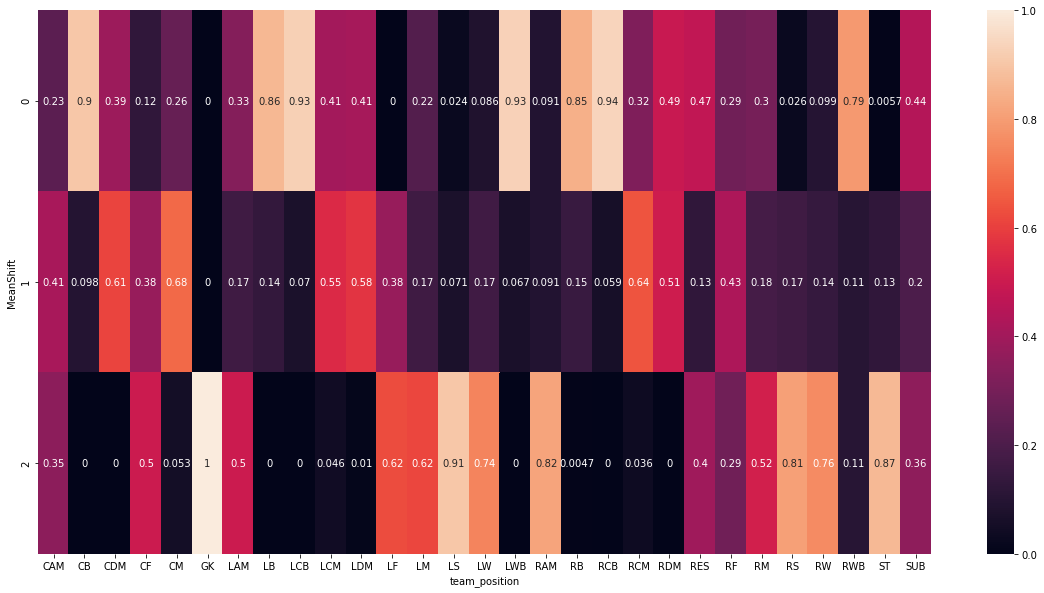

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_clusters.team_position, normalize="columns"),annot=True)

En este caso no se observó una asociación tan clara entre la posición de los jugadores y los clusters. Si bien todos los arqueros (GK) fueron incluidos en el cluster 2, otras posiciónes como los delanteros (LS, ST) y mediocampistas (RAM) también fueron contenidas en este cluster. Sin embargo, el cluster 0 sí mostró una relación con la posición de los jugadores, siendo caracterizado por los defensores (LCB, LWB, RCB). El cluster 1 fue más variable, relacionandose en una proporción menor en comparación con los otros grupos a los jugadores mediocampistas (CM, LDM).

<AxesSubplot:xlabel='club_name', ylabel='MeanShift'>

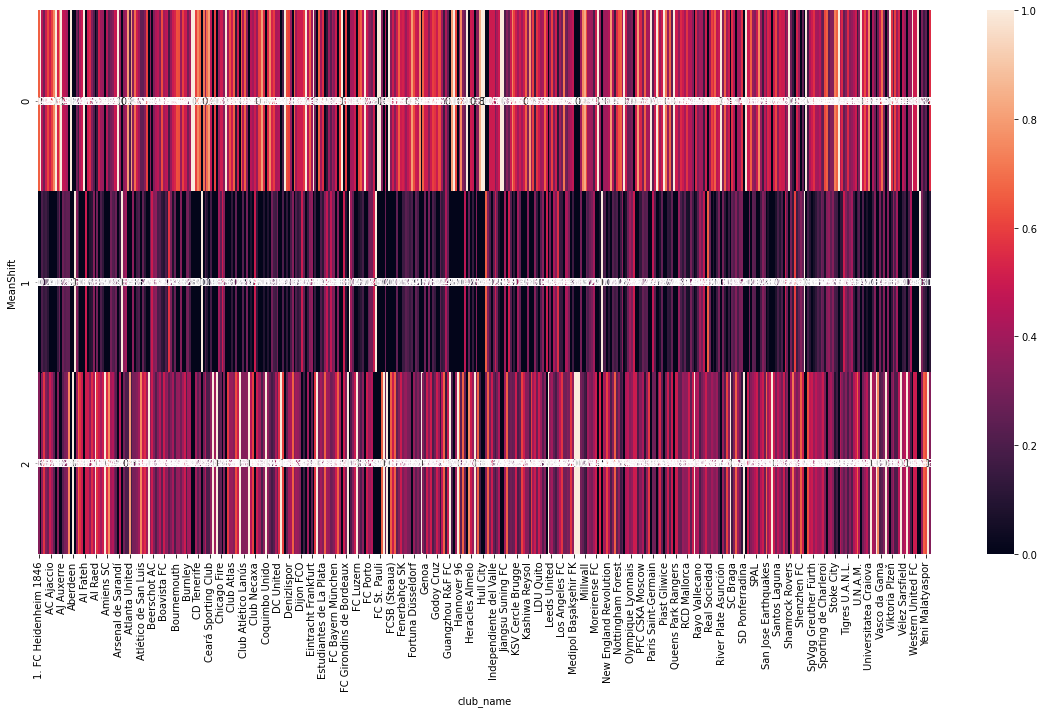

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_clusters.club_name, normalize="columns"),annot=True)

En este gráfico se puede observar una asociación, aunque no muy clara, de ciertos club a determinados clusters. Esto puede evidenciarse observando las proporciones de los clubes en cada cluster (los colores más claros muestran proporciones más altas). **Podemos restringirlo a clubes con mayor cantidad de observaciones si quieren para hacer una interpretación más detallada(Lau)**

<AxesSubplot:xlabel='nationality', ylabel='MeanShift'>

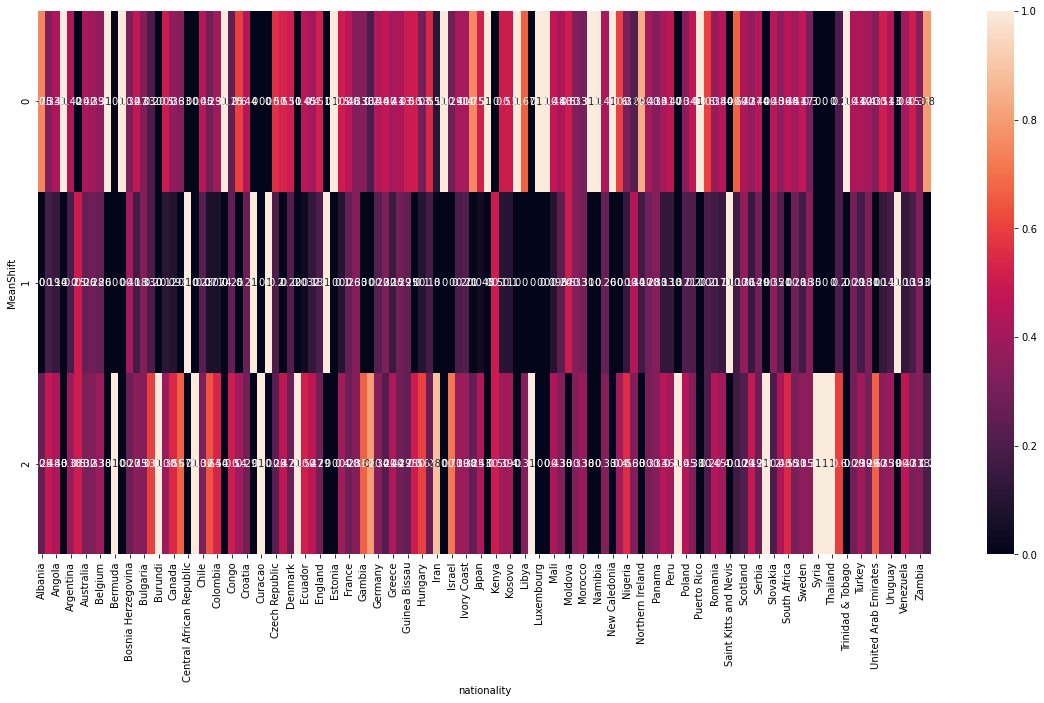

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_clusters.nationality, normalize="columns"),annot=True)

La crosstab mostró una asociación entre ciertas nacionalidades y determinados clusters, evidenciada por las proporciones altas en los clusters. 

<AxesSubplot:xlabel='team_jersey_number', ylabel='MeanShift'>

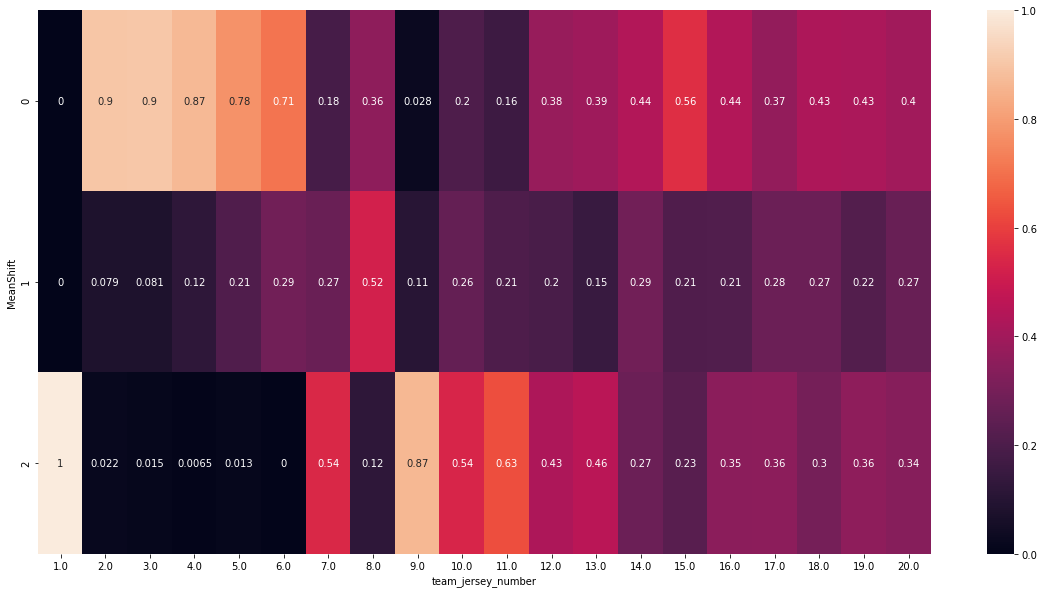

In [37]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters[df_clusters["team_jersey_number"]<=20]["MeanShift"], df_clusters[df_clusters["team_jersey_number"]<=20]["team_jersey_number"], normalize="columns"),annot=True)

Para el caso del número de las camisetas se observó la misma tendencia que con la posición de los jugadores, esto se debe a la estrecha relación que existe entre ambas variables. Podemos ver que el cluster 2 posee una mayor proporción de camisetas con el número que distingue a los arqueros (1) y delanteros (9), mientras que el cluster 0 posse una mayor proporción de jugadores con número de camisetas asociados a las posiciones de defensa (2,3,4). El cluster 1 es más variables, observandose proporciones intermedias de camisetas con el número perteneciente a los mediocampistas (8).

In [38]:
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_skills, clusters2))

Cantidad de clusters encontrados por Mean Shift : 3
Silhouette Coefficient: 0.045


In [39]:
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(df_skills)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

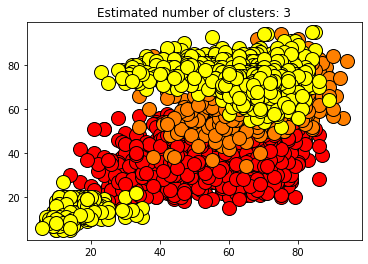

In [40]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]

    xy = df_skills[class_member_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

El método de meanshift aplicado agrupa dos clusters que, como vemos en el gráfico están claramente separados, en uno solo. Esto lo pudimos evidenciar al observar jugadores que poseen posiciones totalmente diferentes (arqueros y delanteros) incluidos en un mismo cluster. Los mismo ocurre cuando analizamos el número de las camisetas. Por esta razón y debido a que el coeficiente de silueta fue muy bajo (0.04), evidenciando un desbalance de clases, podemos argumentar una mayor efectividad del k_means a la hora de determinar los agrupamientos entre jugadores ya que permite la separación de dos grupos que son evidentemente distintos.

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [84]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["player_positions"]!='GK')&(df_n['overall']>69)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 
                  'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle']

df_skills=df_n[skills_ratings]


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

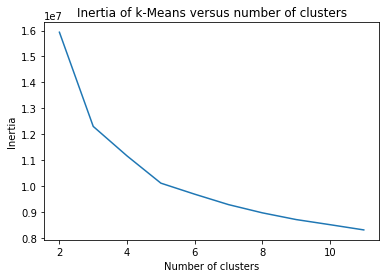

In [85]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

A partir del gráfico de codo podemos observar que el número ótimo de clusters es 3. A continuación se ajustará el modelo con esta cantidad de clusters.

In [86]:
# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [87]:
#data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[27]
skill_2=skills_ratings[9]

In [88]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [53]:
#En Colab
#fig.show(renderer="colab")

In [89]:
#en Jupyter:
plot(fig)

'temp-plot.html'

In [90]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  3 clusters, nosotros forzamos la cantidad


### Número de observaciones por cluster

In [91]:
df_clusters.kmeans.value_counts()

0    1982
2    1746
1    1141
Name: kmeans, dtype: int64

### Análisis descriptivo por cluster 

In [92]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==0]
df_clusters_0.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,1982.000000,1982.000000,1982.000000,1982.000000,1941.000000,1982.000000,1982.000000,1.982000e+03,1982.000000,1982.000000,1982.000000,1982.000000,1.868000e+03,1941.000000,1941.000000,341.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,0.0,0.0,0.0,0.0,0.0,0.0,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,0.0,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.0
mean,211077.429364,27.336529,179.195257,73.900101,1.119526,74.476287,76.723007,7.008918e+06,26532.795156,1.324420,3.153885,2.993441,1.377664e+07,18.122102,2022.249871,11.718475,70.560040,62.423814,70.508073,72.619576,68.276488,71.358729,NaN,NaN,NaN,NaN,NaN,NaN,68.987386,58.039354,60.879919,74.264379,55.905146,71.978305,66.765388,59.267407,70.435419,74.030777,70.899092,70.271948,72.234107,72.271948,71.437941,71.024723,68.677094,77.701816,68.270938,65.235621,71.740666,69.713925,66.284561,69.136226,58.104440,71.437941,NaN,70.362765,67.558527,10.612513,10.684157,10.724016,10.646821,10.659435,0.0
std,23849.773856,3.870867,5.646379,5.925681,0.333885,3.778067,4.677210,7.852087e+06,33289.313282,0.616285,0.688136,0.549845,1.559282e+07,15.348764,1.202620,6.503613,10.072638,7.916908,5.171827,4.986967,6.844729,6.656873,NaN,NaN,NaN,NaN,NaN,NaN,8.077636,10.281130,10.043103,5.308811,11.488338,6.026363,9.775055,12.737482,6.847338,5.057225,10.037884,10.745423,8.293255,5.375286,9.493000,8.185069,10.800970,8.502717,9.410743,9.587267,9.262690,7.204968,7.504786,7.939614,10.646952,6.577993,NaN,6.974540,8.250150,3.310029,3.435442,3.457833,3.617416,3.301684,0.0
min,41.000000,17.000000,163.000000,55.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,2.900000e+05,2.000000,2020.000000,2.000000,30.000000,36.000000,52.000000,55.000000,44.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,32.000000,17.000000,22.000000,52.000000,21.000000,48.000000,31.000000,23.000000,36.000000,50.000000,31.000000,29.000000,34.000000,56.000000,32.000000,28.000000,31.000000,34.000000,24.000000,29.000000,30.000000,41.000000,33.000000,35.000000,25.000000,50.000000,NaN,44.000000,35.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,196553.000000,24.000000,175.000000,70.000000,1.000000,71.000000,73.000000,2.500000e+06,8000.000000,1.000000,3.000000,3.000000,4.800000e+06,8.000000,2021.000000,6.000000,65.000000,57.000000,67.000000,69.000000,65.000000,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,52.000000,55.000000,71.000000,48.000000,68.000000,61.000000,50.000000,66.000000,71.000000,65.000000,64.250000,67.000000,69.000000,66.000000,66.000000,62.000000,73.000000,63.000000,59.000000,67.000000,66.000000,62.000000,65.000000,50.000000,67.000000,NaN,66.000000,63.000000,8.000000,8.000000,

In [95]:
df_clusters_1=df_clusters[df_clusters["kmeans"]==1]
df_clusters_1.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,1141.000000,1141.000000,1141.000000,1141.000000,1120.000000,1141.000000,1141.000000,1.141000e+03,1141.000000,1141.000000,1141.000000,1141.000000,1.077000e+03,1120.000000,1120.000000,142.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,0.0,0.0,0.0,0.0,0.0,0.0,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,0.0,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.0
mean,213360.594216,27.260298,185.138475,79.447853,1.142857,73.127082,75.847502,4.856521e+06,19072.304996,1.217353,2.844873,2.161262,9.543474e+06,15.871429,2022.163393,9.464789,61.451358,41.567046,56.860649,59.273444,72.934268,74.801928,NaN,NaN,NaN,NaN,NaN,NaN,50.127082,35.709027,70.600351,67.121823,35.251534,55.852761,42.678352,37.543383,62.067485,63.967572,60.192813,62.437336,57.790535,69.624014,57.198948,56.024540,72.733567,69.736196,77.425066,40.765995,74.927257,72.607362,43.176161,49.904470,44.055215,66.769500,NaN,74.346188,72.233129,10.709904,10.886065,10.723926,10.705521,10.556529,1.0
std,25334.817523,4.026196,5.731578,6.266322,0.352627,3.135615,4.433274,5.453243e+06,21553.895826,0.502709,0.593490,0.370310,1.084231e+07,14.767894,1.179623,6.607176,12.547403,8.345506,6.718059,7.707292,4.376179,5.384940,NaN,NaN,NaN,NaN,NaN,NaN,14.370125,9.690446,8.072031,5.947288,9.718801,10.325886,11.803098,11.402489,8.225965,6.478426,12.816778,13.113231,11.971272,4.886762,12.267409,12.015754,11.262537,10.303619,8.429836,12.918453,7.754284,4.949756,12.374974,10.937485,9.873566,6.721162,NaN,4.412329,4.629803,3.751839,3.793252,3.456501,3.456884,3.640369,0.0
min,18115.000000,18.000000,165.000000,57.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,3.600000e+05,2.000000,2020.000000,2.000000,30.000000,16.000000,34.000000,34.000000,61.000000,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,12.000000,31.000000,42.000000,11.000000,22.000000,13.000000,10.000000,20.000000,33.000000,28.000000,30.000000,26.000000,53.000000,27.000000,20.000000,31.000000,30.000000,31.000000,12.000000,40.000000,58.000000,12.000000,13.000000,13.000000,46.000000,NaN,61.000000,57.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.0
25%,199191.000000,24.000000,182.000000,75.000000,1.000000,71.000000,72.000000,2.000000e+06,7000.000000,1.000000,2.000000,2.000000,3.800000e+06,4.000000,2021.000000,4.000000,54.000000,35.000000,53.000000,54.000000,70.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,29.000000,67.000000,64.000000,28.000000,49.000000,33.000000,30.000000,57.000000,60.000000,53.000000,54.000000,51.000000,67.000000,50.000000,47.000000,68.000000,65.000000,73.000000,30.000000,71.000000,69.000000,33.000000,43.000000,37.000000,62.000000,NaN,71.000000,69.000000,8.000000,8

In [96]:
df_clusters_2=df_clusters[df_clusters["kmeans"]==2]
df_clusters_2.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans
count,1746.000000,1746.000000,1746.000000,1746.000000,1713.000000,1746.000000,1746.000000,1.746000e+03,1746.000000,1746.000000,1746.000000,1746.000000,1.635000e+03,1713.000000,1713.000000,258.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,0.0,0.0,0.0,0.0,0.0,0.0,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,0.0,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.0
mean,212361.313288,27.079611,179.065865,74.230813,1.115003,74.072165,76.395762,7.358663e+06,25219.644903,1.340779,3.355097,3.326460,1.439936e+07,18.713368,2022.273789,14.124031,75.677549,71.359107,66.828751,74.681558,37.028637,65.406644,NaN,NaN,NaN,NaN,NaN,NaN,64.633448,71.993127,60.654066,70.569874,66.482818,74.905498,66.870561,59.664948,60.820160,74.794960,75.961054,75.446163,75.872852,71.520619,71.924399,74.038946,66.549828,69.613402,66.275487,68.931271,57.613402,34.029210,73.514891,68.601947,66.907216,70.989118,NaN,33.896334,29.812142,10.528064,10.522337,10.624284,10.525773,10.483963,2.0
std,27088.296313,4.086454,6.750631,7.158139,0.320944,3.851015,4.996820,9.414186e+06,36375.926548,0.667818,0.701958,0.615892,1.851184e+07,16.237365,1.282656,5.166501,10.296116,5.488610,7.353529,5.428723,7.870170,9.071928,NaN,NaN,NaN,NaN,NaN,NaN,11.066701,6.375720,13.944776,5.806230,8.744445,5.910770,10.843739,13.874488,10.520699,5.184537,10.913816,10.382745,10.313198,6.017251,12.162934,6.590753,13.348882,9.171153,13.306794,7.197650,13.932174,10.986512,5.999814,8.018687,8.723941,6.879178,NaN,11.107504,9.936082,3.122075,3.078312,3.143696,3.122461,3.182874,0.0
min,3467.000000,17.000000,157.000000,56.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,7.190000e+05,2.000000,2020.000000,3.000000,30.000000,54.000000,44.000000,57.000000,18.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,46.000000,20.000000,51.000000,32.000000,57.000000,21.000000,22.000000,21.000000,53.000000,27.000000,30.000000,30.000000,52.000000,27.000000,39.000000,28.000000,30.000000,27.000000,38.000000,23.000000,10.000000,53.000000,39.000000,31.000000,50.000000,NaN,11.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
25%,199079.250000,24.000000,174.000000,69.000000,1.000000,71.000000,72.000000,2.500000e+06,8000.000000,1.000000,3.000000,3.000000,4.800000e+06,9.000000,2021.000000,10.000000,70.000000,68.000000,62.000000,71.000000,31.000000,60.000000,NaN,NaN,NaN,NaN,NaN,NaN,60.000000,68.000000,49.000000,67.000000,61.000000,71.000000,61.000000,49.000000,55.000000,71.000000,70.000000,70.000000,70.000000,68.000000,65.000000,70.000000,58.000000,65.000000,58.000000,65.000000,47.000000,25.000000,70.000000,64.000000,61.000000,67.000000,NaN,25.000000,22.000000,8.000000,

A partir de las medidas resumen por cluster podemos observar un clara diferenciación entre el cluster 0 y 2 respecto del cluster 1. Los cluster 0 y 2 fueron más similares entre sí cuando se analizaron las variables peso, altura y sueldo de los jugadores. Los jugadores pertenecientes al cluster 1 poseen en promedio mayor peso y altura, así como también, menores salarios que los jugadores incluidos en los clusters 0 y 2.

<AxesSubplot:xlabel='team_position', ylabel='kmeans'>

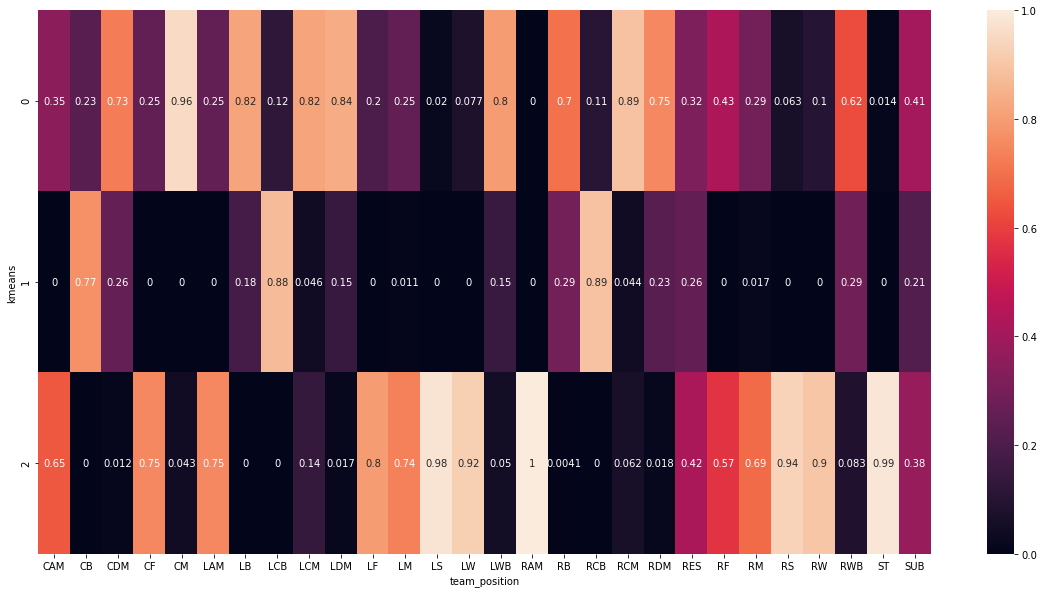

In [97]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_n.team_position, normalize='columns'),annot=True)

A partir de la crosstab podemos observar una evidente asociación entre clusters y posiciones de los jugadores. En el cluster 0 podemos ver una mayor proporción de jugadores mediocampistas (CM, RCM), mientras que en el cluster 2 están incluidos en mayor porporción los jugadores que son delanteros (LS, RS, ST). Por último, en el cluster 1 se encuentran en mayor proporción los jugadores que son defensores (LCB, RCB).

<AxesSubplot:xlabel='team_jersey_number', ylabel='kmeans'>

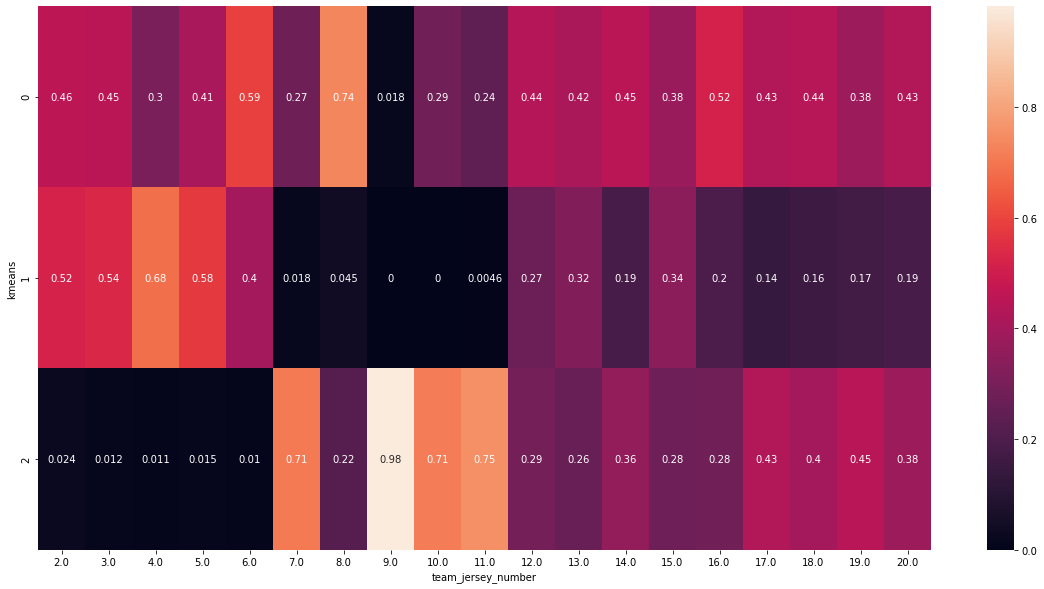

In [98]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters[df_clusters["team_jersey_number"]<=20]["kmeans"], df_clusters[df_clusters["team_jersey_number"]<=20]["team_jersey_number"], normalize="columns"),annot=True)

No existe una asociación clara entre los clusters y el número de camiseta de los jugadores. Aunque podemos ver una gran porporción de jugadores con la camiseta 9 en el cluster 1 que correspondería a los delanteros.

<AxesSubplot:xlabel='club_name', ylabel='kmeans'>

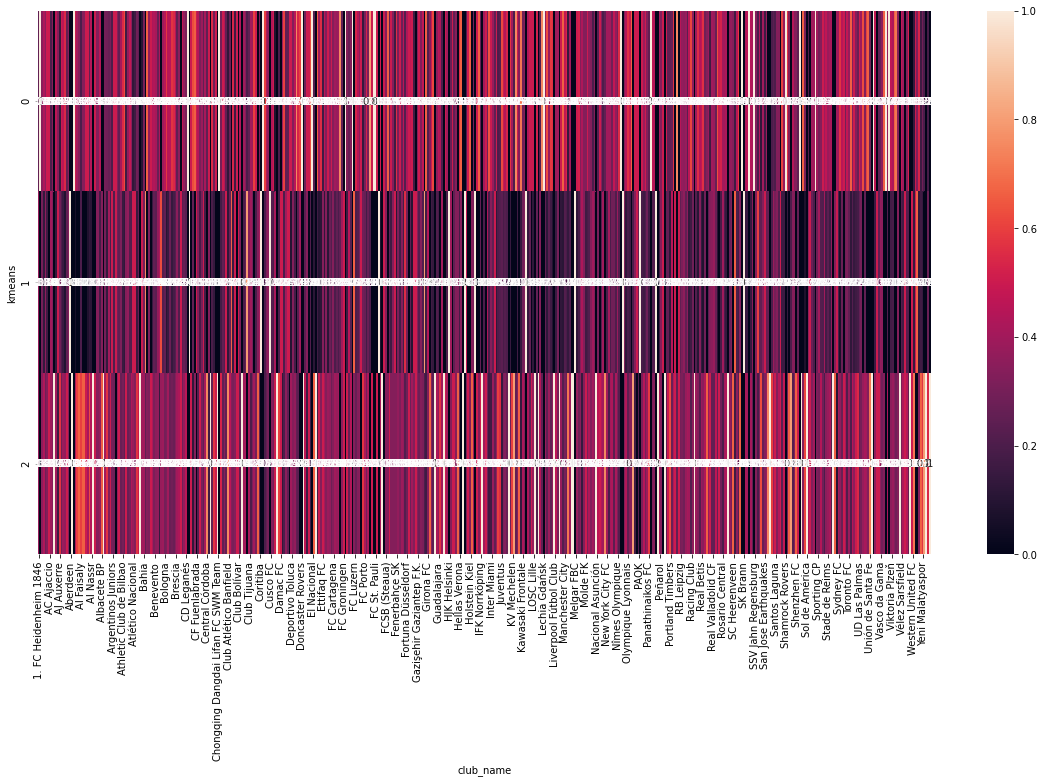

In [99]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_clusters.club_name, normalize="columns"),annot=True)

<AxesSubplot:xlabel='nationality', ylabel='kmeans'>

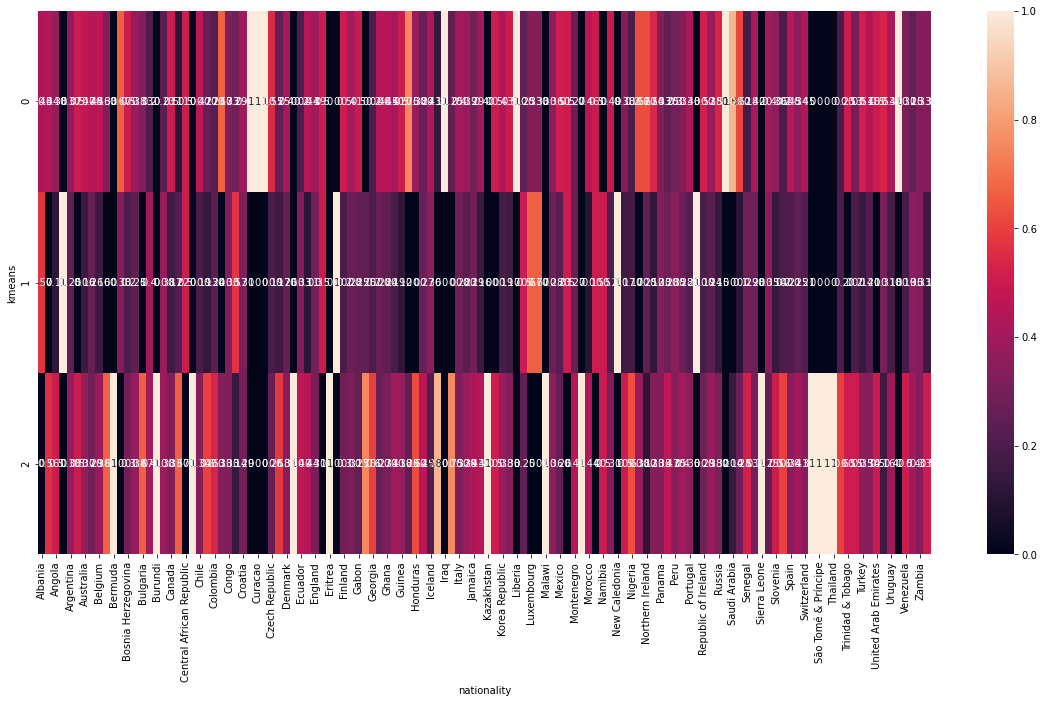

In [100]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.kmeans, df_clusters.nationality, normalize="columns"),annot=True)

Los tablas de contingencia que asocian los clusters con clubes y nacionalidad de los jugadores muestran una cierta asociación aunque no muy clara. 

Automatically created module for IPython interactive environment
Para n_clusters = 2 El silhouette_score promedio es : 0.28551410157808604
Para n_clusters = 3 El silhouette_score promedio es : 0.2594711288690315
Para n_clusters = 4 El silhouette_score promedio es : 0.22442466243907888
Para n_clusters = 5 El silhouette_score promedio es : 0.18427562633909184
Para n_clusters = 6 El silhouette_score promedio es : 0.1627069781936693


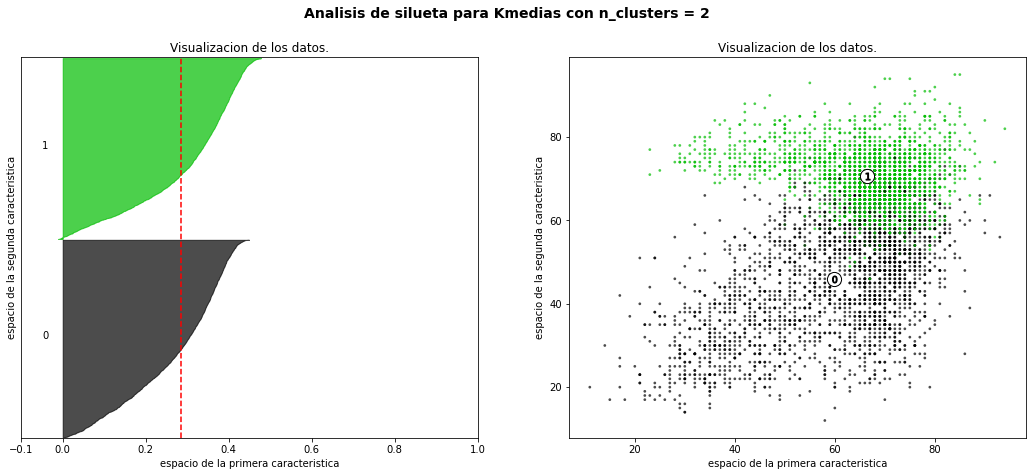

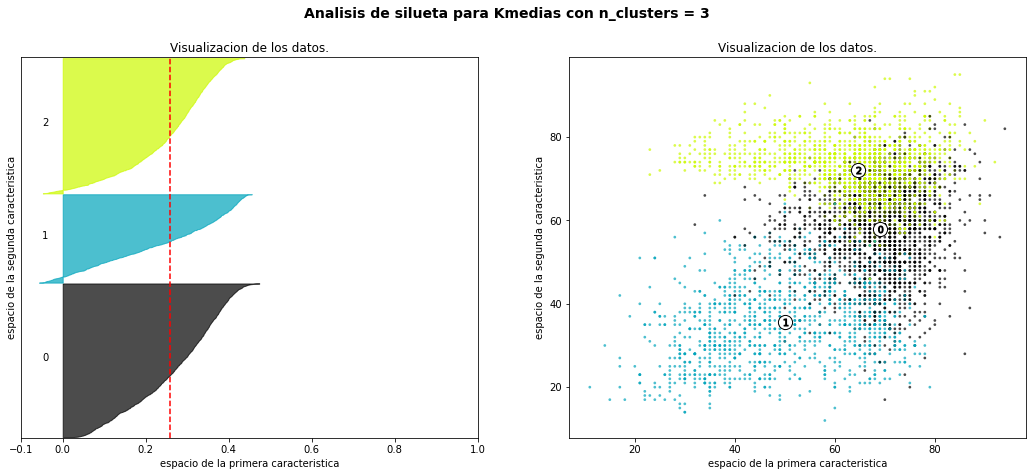

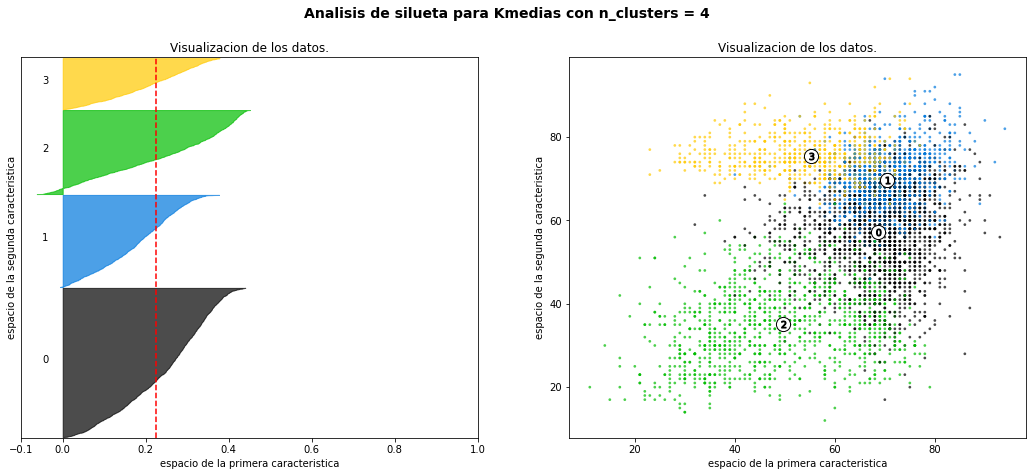

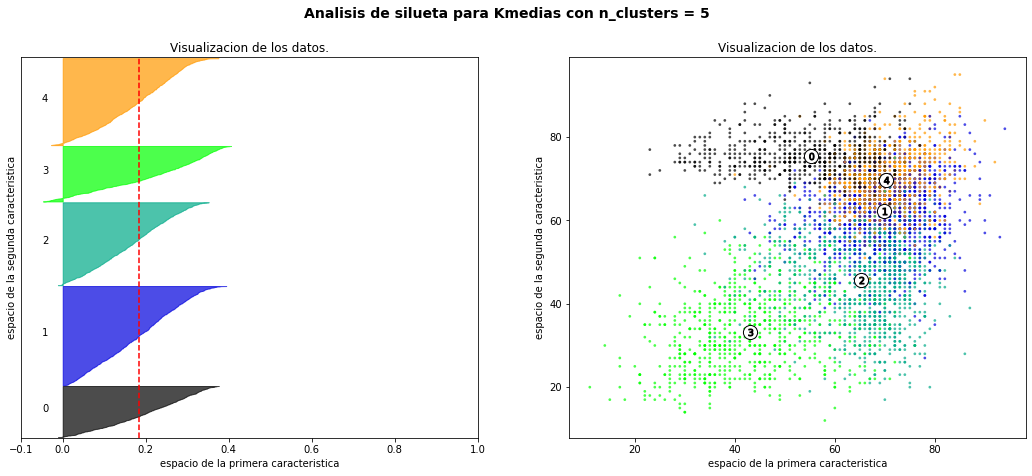

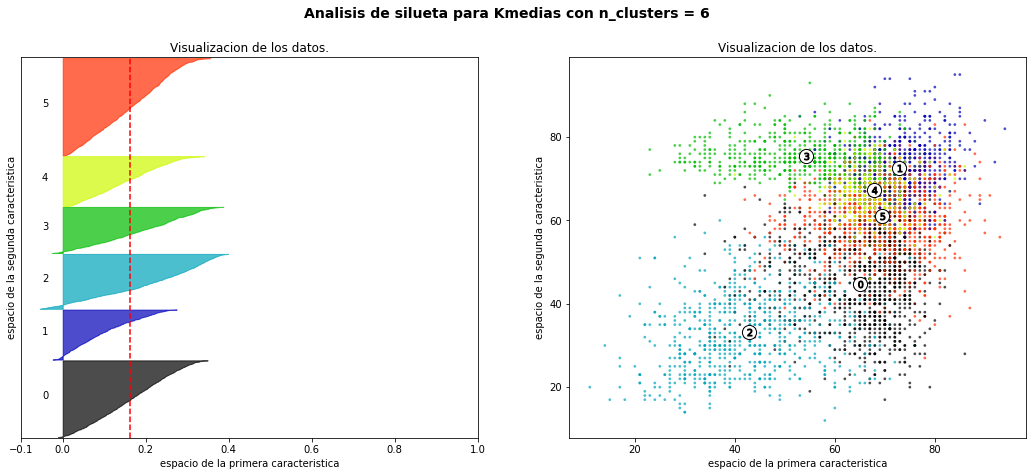

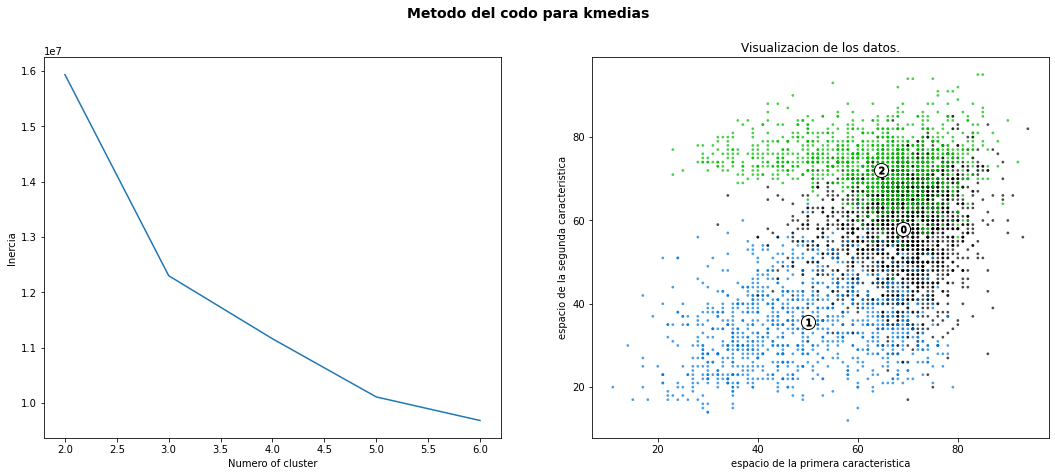

In [101]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X=df_skills

range_n_clusters = [2,3, 4, 5, 6]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()

**Acá también pareciera que es mejor el de dos grupos, más balanceado y menos valores negativos (Lau)** 
Duda! 

**COMENT FC** Coincido con Lau en que se ve mejor, sino podría ser 4 clusters pero ahi ya tenemos valores negativos que me hacen dudar.

El método de kmeans muestra un agrupamiento de clusters que está asociado principalmente a la posición de los jugadores como se mencionó anteriormente. Además se pudieron detectar otras variables que podrían diferenciar a los mismos, tales como la nacionalidad de los jugadores, el club al cual pertenecen y variables numéricas como la altura y el salario que permiten diferenciar al cluster 1 de los clusters 0 y 2 que son más similares entre sí. 

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [102]:
ms = MeanShift(bandwidth=6, bin_seeding=True) ## Con bandwidth por defecto me tira 1 cluster, con 5 tira 2 clusters y con 6 3 clusters

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 3


In [103]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[27]
skill_2=skills_ratings[9]
print(skill_1,skill_2)

defending_sliding_tackle skill_ball_control


In [104]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [58]:
#En Colab
#fig.show(renderer="colab")

In [105]:
#En Jupyter
plot(fig)

'temp-plot.html'

In [62]:
#df_clusters=df_skills
#df_clusters['kmeans'] = km.labels_ #clusters
#df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**

In [106]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  3 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


In [107]:
df_clusters.MeanShift.value_counts() 

0    2093
1    1604
2    1172
Name: MeanShift, dtype: int64

In [108]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==0]
df_clusters_0.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,2093.000000,2093.000000,2093.000000,2093.000000,2057.000000,2093.000000,2093.000000,2.093000e+03,2093.000000,2093.000000,2093.000000,2093.000000,1.981000e+03,2057.000000,2057.000000,375.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,0.0,0.0,0.0,0.0,0.0,0.0,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,0.0,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.0
mean,209069.176302,27.622551,179.502150,74.329193,1.106952,74.825609,76.865743,7.725024e+06,29034.161491,1.385093,3.190635,3.016245,1.507804e+07,17.789499,2022.230919,11.944000,69.648829,63.664118,70.873387,72.662207,67.262781,71.629240,NaN,NaN,NaN,NaN,NaN,NaN,68.571906,59.125657,61.551362,74.621596,57.374104,72.010989,67.500239,61.150502,70.915910,74.297659,69.993311,69.353082,71.722886,72.741997,70.980411,72.489728,68.977066,77.203058,68.904921,66.760631,72.033923,68.585762,66.449594,69.738175,59.542762,72.159102,NaN,69.172002,65.963688,10.623507,10.659341,10.749642,10.624462,10.614907,0.207358,0.0
std,24363.166434,3.898314,5.841732,6.217465,0.318428,3.995776,4.762288,9.134107e+06,37140.622184,0.675866,0.692398,0.606469,1.790418e+07,14.847242,1.210226,6.384269,10.696913,8.121710,5.408523,5.915441,8.451455,6.859847,NaN,NaN,NaN,NaN,NaN,NaN,8.982946,11.158170,10.586341,5.288896,11.829616,6.961748,10.131102,12.348501,6.540329,5.585318,10.757671,11.291295,9.435939,5.568394,10.328685,7.338348,11.123006,8.844166,9.807860,8.836498,9.516128,9.032072,9.025562,8.106147,10.842771,6.613331,NaN,8.802162,10.453193,3.272906,3.301754,3.414261,3.426420,3.253592,0.564233,0.0
min,41.000000,17.000000,158.000000,55.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,2.900000e+05,2.000000,2020.000000,2.000000,30.000000,39.000000,53.000000,45.000000,40.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,17.000000,22.000000,52.000000,12.000000,38.000000,22.000000,25.000000,42.000000,42.000000,30.000000,29.000000,30.000000,54.000000,30.000000,28.000000,31.000000,34.000000,30.000000,30.000000,29.000000,29.000000,20.000000,35.000000,27.000000,50.000000,NaN,36.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0
25%,193301.000000,25.000000,175.000000,70.000000,1.000000,72.000000,73.000000,2.600000e+06,8000.000000,1.000000,3.000000,3.000000,4.800000e+06,8.000000,2021.000000,6.000000,64.000000,58.000000,67.000000,69.000000,63.000000,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,52.000000,55.000000,71.000000,49.000000,68.000000,61.000000,52.000000,67.000000,71.000000,64.000000,64.000000,66.000000,69.000000,65.000000,68.000000,62.000000,72.000000,63.000000,61.000000,67.000000,64.000000,62.000000,65.000000,52.000000,

In [109]:
df_clusters_1=df_clusters[df_clusters["MeanShift"]==1]
df_clusters_1.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,1604.000000,1604.000000,1604.000000,1604.000000,1569.000000,1604.000000,1604.000000,1.604000e+03,1604.000000,1604.000000,1604.000000,1604.000000,1.494000e+03,1569.000000,1569.000000,223.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,0.0,0.0,0.0,0.0,0.0,0.0,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,0.0,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.0
mean,213345.503741,26.946384,179.216334,74.389027,1.123646,73.705736,76.141521,6.613186e+06,22602.556110,1.296758,3.339152,3.291147,1.300399e+07,19.124283,2022.267686,14.170404,75.754364,70.924564,66.049252,74.260599,35.955112,65.189526,NaN,NaN,NaN,NaN,NaN,NaN,63.764963,71.708853,60.711347,69.998130,65.904613,74.501870,65.800499,58.315461,59.892768,74.334788,75.950125,75.598504,75.564838,71.031172,71.389651,73.539900,66.513716,69.137157,66.410848,68.270574,56.803616,32.711347,73.155237,67.861596,66.377182,70.394638,NaN,32.492519,28.708853,10.531796,10.494389,10.595387,10.529925,10.488155,1.976309,1.0
std,27128.166120,4.096572,6.817464,7.224985,0.331213,3.556961,4.918352,8.149406e+06,31915.455607,0.610136,0.701794,0.608237,1.627605e+07,16.817575,1.282131,5.155040,10.340830,5.437553,7.012026,5.294276,7.188435,9.138171,NaN,NaN,NaN,NaN,NaN,NaN,10.956341,6.335644,13.986076,5.501148,8.748172,5.811179,10.659833,13.628764,10.226736,4.976252,11.018897,10.377631,10.444406,5.762098,12.293242,6.637313,13.282682,9.067289,13.452633,7.054753,13.847560,10.304272,5.884962,7.770623,8.748400,6.668760,NaN,10.327480,9.444887,3.082296,3.043145,3.105989,3.075629,3.131628,0.216447,0.0
min,3467.000000,17.000000,157.000000,56.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,7.190000e+05,2.000000,2020.000000,3.000000,30.000000,54.000000,44.000000,57.000000,18.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,46.000000,20.000000,51.000000,32.000000,57.000000,21.000000,22.000000,21.000000,53.000000,27.000000,30.000000,30.000000,52.000000,27.000000,39.000000,28.000000,30.000000,27.000000,38.000000,23.000000,10.000000,53.000000,39.000000,31.000000,50.000000,NaN,11.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0
25%,199823.250000,24.000000,175.000000,69.750000,1.000000,71.000000,72.000000,2.475000e+06,7000.000000,1.000000,3.000000,3.000000,4.700000e+06,9.000000,2021.000000,10.000000,70.000000,68.000000,62.000000,71.000000,31.000000,59.000000,NaN,NaN,NaN,NaN,NaN,NaN,59.000000,68.000000,49.000000,66.000000,60.000000,71.000000,60.000000,48.000000,54.000000,71.000000,70.000000,70.000000,70.000000,67.000000,65.000000,70.000000,58.000000,65.000000,58.000000,64.000000,46.750000,24.000000,69.000000,64.000000,61.0

In [110]:
df_clusters_2=df_clusters[df_clusters["MeanShift"]==2]
df_clusters_2.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,kmeans,MeanShift
count,1172.000000,1172.00000,1172.000000,1172.000000,1148.000000,1172.000000,1172.000000,1.172000e+03,1172.000000,1172.000000,1172.000000,1172.000000,1.105000e+03,1148.000000,1148.000000,143.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,0.0,0.0,0.0,0.0,0.0,0.0,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,0.0,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.0
mean,215695.206485,26.90273,184.211604,78.358362,1.152439,72.991468,75.924061,4.697240e+06,18225.255973,1.174061,2.833618,2.231229,9.283704e+06,16.034843,2022.210801,9.405594,63.834471,41.581058,57.190273,60.376280,72.304608,73.803754,NaN,NaN,NaN,NaN,NaN,NaN,52.029010,36.439420,69.038396,67.007679,35.247440,57.127986,43.480375,36.650171,61.534983,64.479522,62.721843,64.703925,59.947952,69.433447,59.183447,54.853242,71.882253,70.509386,75.623720,40.041809,73.715870,72.025597,44.860922,50.286689,43.650171,66.364334,NaN,73.870307,71.894198,10.672355,10.943686,10.705631,10.723549,10.611775,0.877986,2.0
std,24180.253335,3.93097,6.190508,6.562677,0.362019,2.958857,4.414308,4.855470e+06,19886.538375,0.456934,0.590673,0.427829,9.684311e+06,14.916583,1.179964,6.683212,12.971423,8.172526,6.846903,8.313409,4.455516,5.795318,NaN,NaN,NaN,NaN,NaN,NaN,15.323135,10.227669,8.973977,5.757328,9.431684,11.008684,12.410518,10.086922,8.042350,6.522019,13.471205,13.285805,12.737641,4.727033,13.006783,10.984453,11.391404,10.265847,9.555227,11.801697,8.152076,4.918397,13.388829,11.009105,9.306094,6.483601,NaN,4.428026,4.556213,3.824746,3.987843,3.541801,3.791585,3.756731,0.327441,0.0
min,18115.000000,18.00000,165.000000,57.000000,1.000000,70.000000,70.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,3.600000e+05,2.000000,2020.000000,2.000000,30.000000,16.000000,34.000000,34.000000,58.000000,46.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,12.000000,31.000000,42.000000,11.000000,22.000000,13.000000,10.000000,20.000000,33.000000,28.000000,30.000000,26.000000,53.000000,27.000000,20.000000,31.000000,30.000000,24.000000,12.000000,40.000000,55.000000,12.000000,13.000000,13.000000,46.000000,NaN,58.000000,54.000000,3.000000,3.000000,1.000000,3.000000,3.000000,0.000000,2.0
25%,201156.250000,24.00000,180.000000,74.000000,1.000000,71.000000,72.000000,2.000000e+06,7000.000000,1.000000,2.000000,2.000000,3.900000e+06,4.000000,2021.000000,4.000000,56.000000,36.000000,53.000000,54.000000,69.000000,71.000000,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,29.000000,64.000000,64.000000,29.000000,50.000000,33.000000,30.000000,57.000000,61.000000,55.000000,57.000000,52.000000,66.000000,51.000000,47.000000,66.000000,66.000000,71.000000,31.000000,69.000000,69.000000,34.000000,43.000000,37.000000

Como podemos observar, el cluster 2 se diferencia de los clusters 0 y 1 en relación a las variables altura, peso y salario. Los jugadores pertenecientes al cluster 2 poseen en promedio mayor altura y peso y, menores salarios que los jugadores pertenecientes a los clusters 0 y 1.

<AxesSubplot:xlabel='team_position', ylabel='MeanShift'>

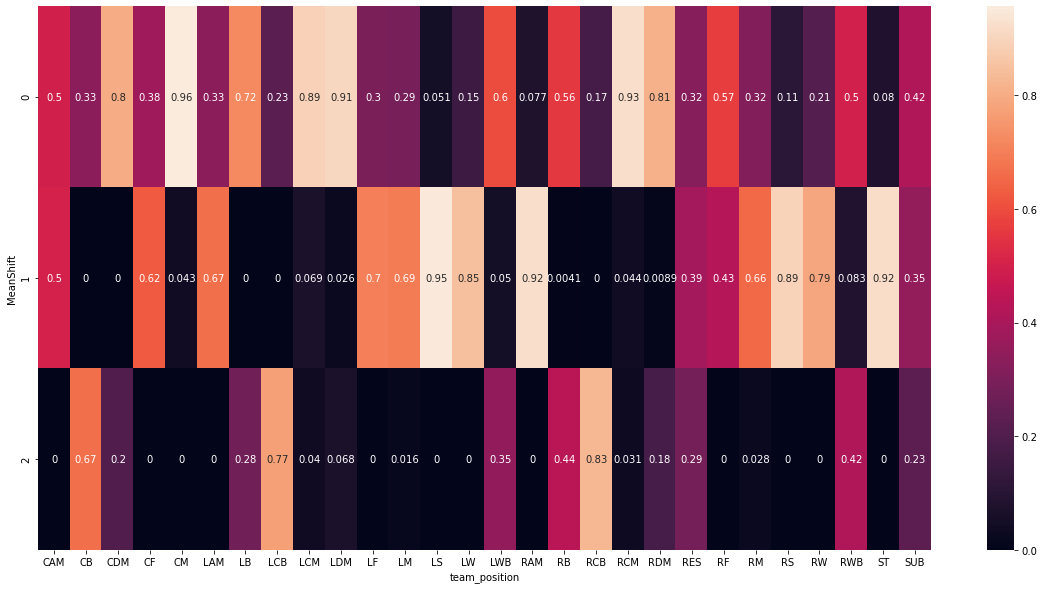

In [111]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_n.team_position, normalize='columns'),annot=True)

A partir de la crosstab podemos observar una estrecha asociación entre clusters y posiciones de los jugadores. En el cluster 0 podemos ver una mayor proporción de jugadores mediocampistas (CM, RCM, LCM), mientras que en el cluster 2 están incluidos en mayor porporción los jugadores que son defensores (LCB, RCB). Por último, en el cluster 1 se encuentran en mayor proporción los jugadores que son delanteros (LS, RS, ST).

<AxesSubplot:xlabel='team_jersey_number', ylabel='MeanShift'>

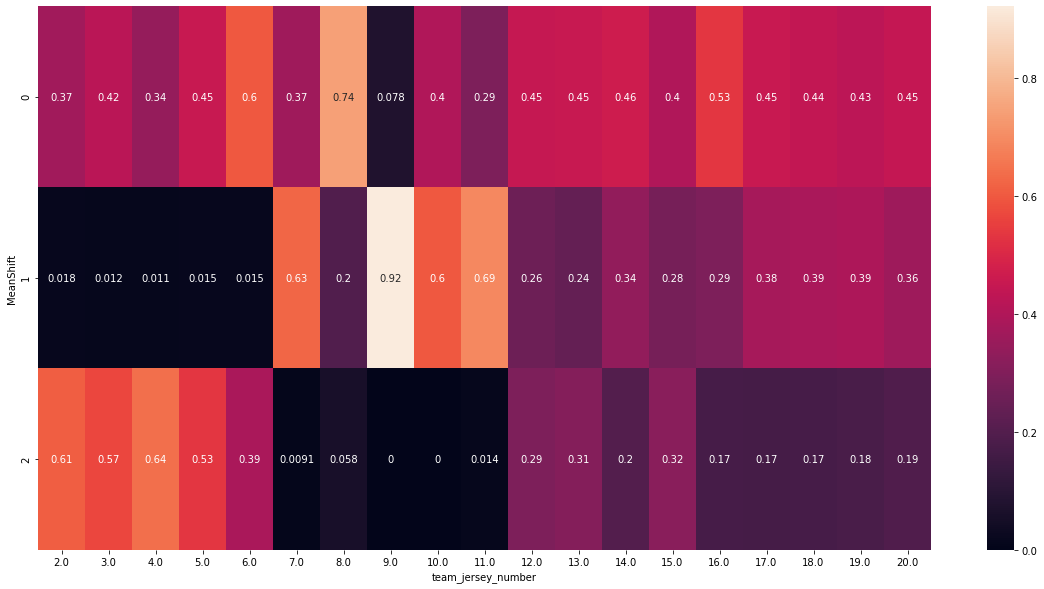

In [112]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters[df_clusters["team_jersey_number"]<=20]["MeanShift"], df_clusters[df_clusters["team_jersey_number"]<=20]["team_jersey_number"], normalize="columns"),annot=True)

No existe una asociación clara entre los clusters y el número de camiseta. Sólo en el caso del cluster 1 podemos observar una mayor porporción de jugadores con camiseta número 9 que corresponde a los delanteros, los cuales a su vez se encontraron también en mayor proporción en este cluster.

<AxesSubplot:xlabel='nationality', ylabel='MeanShift'>

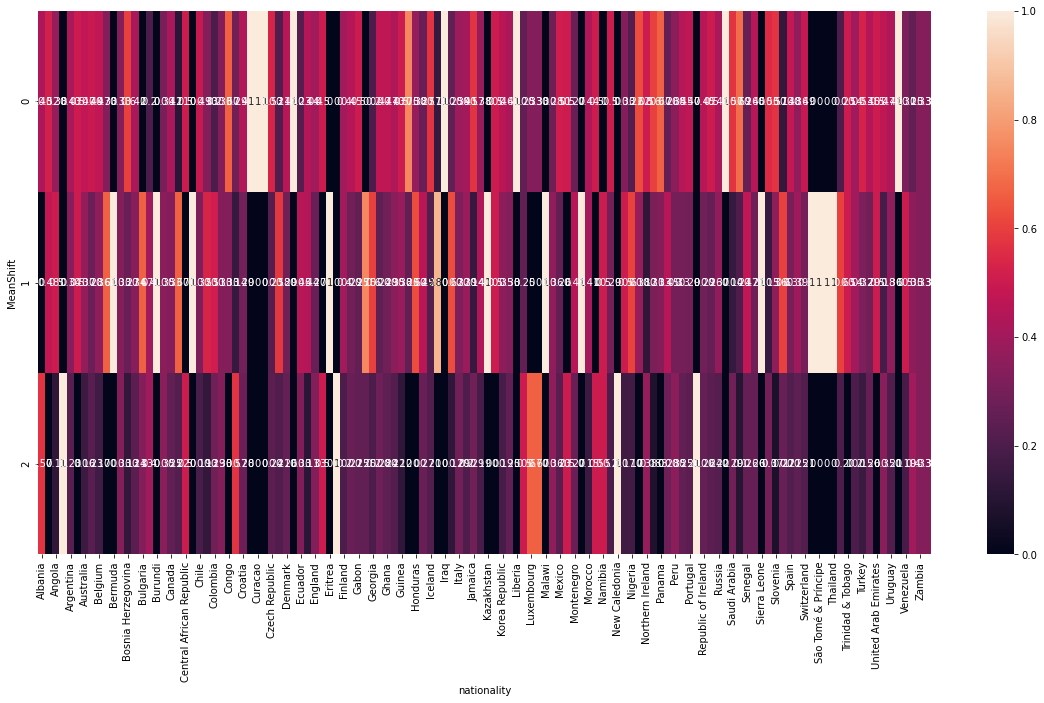

In [76]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_clusters.nationality, normalize="columns"),annot=True)

<AxesSubplot:xlabel='club_name', ylabel='MeanShift'>

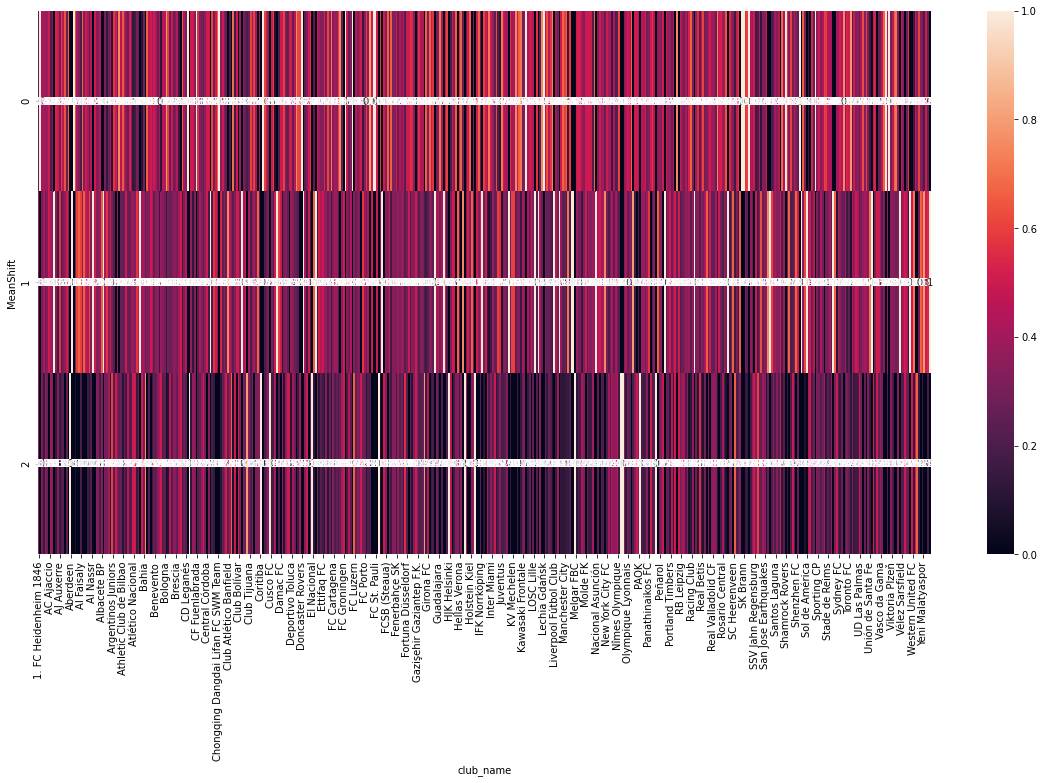

In [77]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df_clusters.MeanShift, df_clusters.club_name, normalize="columns"),annot=True)

En estos dos últimos heatmaps podemos ver que ciertas nacionalidades y clubes se asocian a determinados clusters.

In [113]:
ms = MeanShift(bandwidth=6, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_skills, clusters2))

Cantidad de clusters encontrados por Mean Shift : 3
Silhouette Coefficient: 0.245


In [114]:
ms = MeanShift(bandwidth=6, bin_seeding=True)
ms.fit(df_skills)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

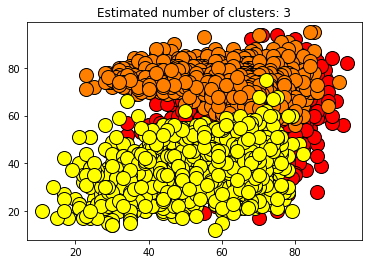

In [115]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]

    xy = df_skills[class_member_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()



Cuando analizamos los datos excluyendo a los arqueros, ambos métodos (k_means y meanshift) mostraron resultados similares,   grupando a los jugadores en tres clusters diferenciados principalmente en relación a la posición de los jugadores. Sin embargo, existen también asociaciones entre los clusters y variables numéricas como el peso, la altura y el salario, así como también, con otras variables categórcias como la nacionalidad de los jugadores y los clubes a los cuales pertenecen.